In [1]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
from Bio import Phylo
import os
from matplotlib import gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
from Bio import SeqIO
from scipy.stats import fisher_exact

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


# Import data

Start by importing some of the main things

In [2]:
gff = (
    pl.read_csv(
        "../results/final_annotation/final_annotation.gff",
        separator="\t",
        has_header=False,
        comment_prefix="#",
    )
    .rename(
        {
            "column_1": "seqid",
            "column_2": "source",
            "column_3": "type",
            "column_4": "start",
            "column_5": "end",
            "column_6": "score",
            "column_7": "strand",
            "column_8": "phase",
            "column_9": "attributes",
        }
    )
    .with_columns(
        pl.col("attributes").str.extract(r"ID=(.*?)(?:;|$)").alias("ID"),
        pl.col("attributes").str.extract(r"Parent=(.*?)(?:;|$)").str.split(by=".").alias("Parent"),
    )
    .with_columns(
        (
            pl
            .when(pl.col("Parent").is_null())
            .then(pl.col("ID"))
            .otherwise(pl.col("Parent").list.get(0))
            .alias("gene")
        ),
        (
            pl
            .when(pl.col("Parent").list.len() == 1)
            .then(pl.col("ID").str.split(by=".").list.get(1).str.extract(r"(\d+)"))
            .otherwise(pl.col("Parent").list.get(1).str.extract(r"(\d+)"))
            .cast(pl.Int32)
            .alias("transcript")
        )
    )
    .select([
        "seqid",
        "start",
        "end",
        "strand",
        "gene",
        "transcript",
        "type",
        "attributes",
    ])
)

de_genes = pl.read_csv(
    "../results/differential_expression.tsv",
    separator="\t",
    has_header=True,
)

lcpm = (
    pl.read_csv(
        "../results/tpm.tsv",
        separator="\t",
        has_header=True,
    )
    .with_columns((pl.col("tpm") + 1).log10().alias("log_tpm"))
)

Plot the distribution of some genetic features across the genome.
Use the bedtools window summaries for this.

In [3]:
gc = (
    pl.read_csv(
        "../results/windows/gc.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("gc").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_5").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

genes = (
    pl.read_csv(
        "../results/windows/genes.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("genes").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty1 = (
    pl.read_csv(
        "../results/windows/Ty1.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty1").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

ty3 = (
    pl.read_csv(
        "../results/windows/Ty3.bed",
        has_header = False,
        separator = "\t",
        comment_prefix="#",
    )
    .with_columns(
        [
            (pl.lit("ty3").alias("feature")),
            (pl.col("column_1").alias("chrom")),
            (pl.col("column_2").alias("start")),
            (pl.col("column_3").alias("end")),
            (pl.col("column_7").alias("proportion")),
        ]
    )
    .select(["feature", "chrom", "start", "end", "proportion"])
)

methylation = (
    pl.read_csv(
        "../results/windows/methylation.tab",
        has_header=False,
        separator="\t",
        comment_prefix="#",
    )
    .rename(
        {
            "column_1": "chrom",
            "column_2": "start",
            "column_3": "end",
            "column_4": "CG",
            "column_5": "CHG",
            "column_6": "CHH",
        }
    )
    .melt(id_vars=["chrom", "start", "end"], variable_name="feature", value_name="proportion")
)

features_df = pl.concat([gc, genes, ty1, ty3, methylation], how = "align")

# Remove the scaffolds, BORING
features_df = features_df.filter(pl.col("chrom").str.contains("chr"))

Plot the windows

Need to polish this up for final genome.

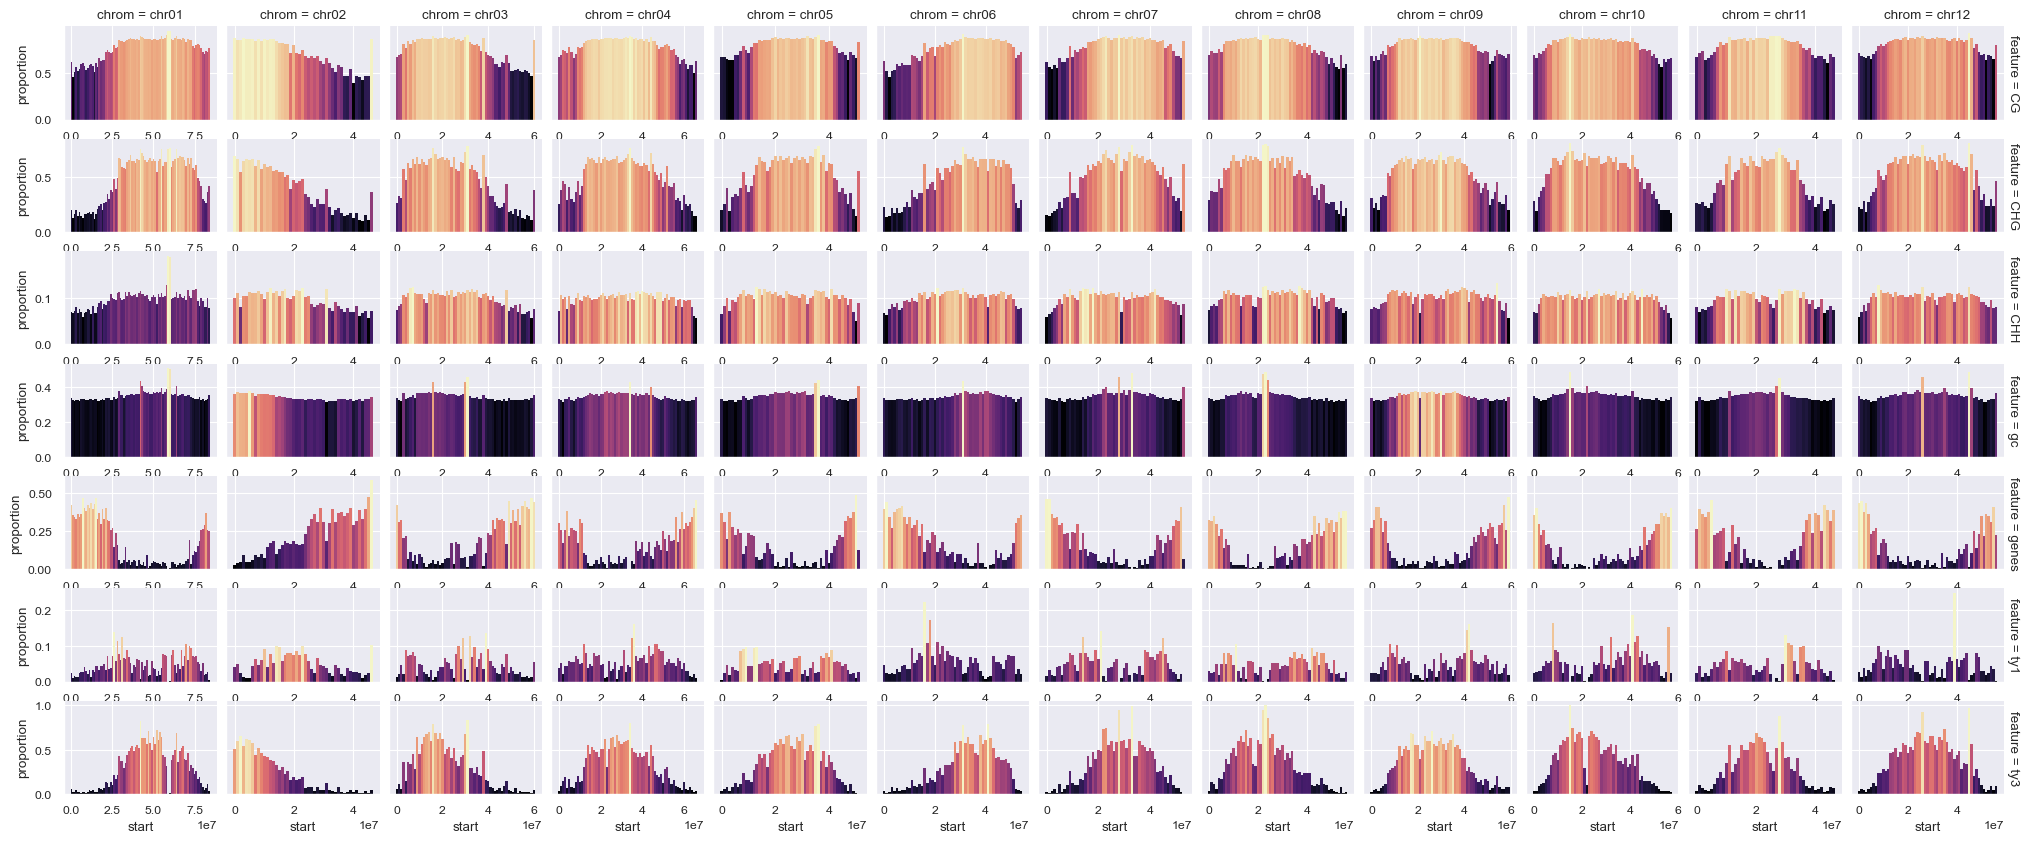

In [4]:
plot = sns.FacetGrid(
    features_df,
    col="chrom",
    row="feature",
    sharex=False,
    sharey="row",
    margin_titles=True,
)

plot.map_dataframe(
    sns.barplot,
    x="start",
    y="proportion",
    hue="proportion",
    width=1,
    native_scale=True,
    linewidth=0,
    palette="magma",
)
plot.fig.set_size_inches(20, 8)
plot.savefig(
    "../../pandoc-thesis/figures/genomic_windows.png",

    dpi=300
)

# RNA seq

Plot MA across conditions

[<matplotlib.collections.PathCollection object at 0x32e62e800>, <matplotlib.collections.PathCollection object at 0x32e6e7b20>]


<Figure size 3540x1800 with 0 Axes>

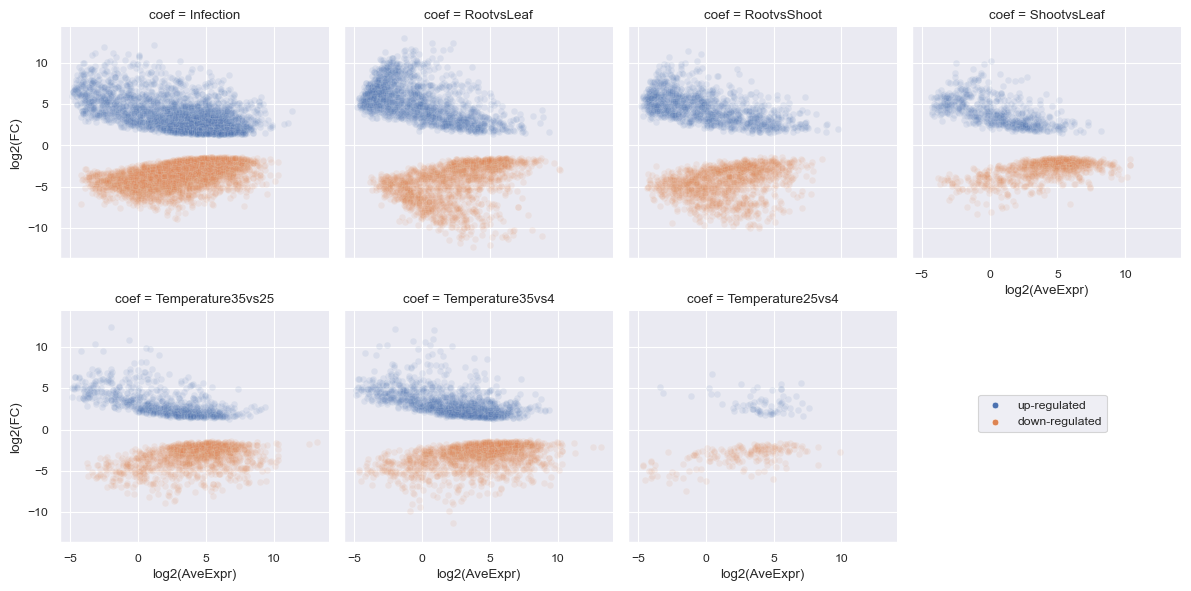

In [5]:


plt.figure(figsize=(5.9, 3), dpi=600)
ma_plot = sns.FacetGrid(
    de_genes.filter(pl.col("status") != "not significant"),
    col="coef",
    col_wrap=4,
    hue="status",
)
ma_plot = ma_plot.map(
    sns.scatterplot,
    "AveExpr",
    "logFC",
    alpha=0.1
)
ma_plot.set(xlabel="log2(AveExpr)", ylabel="log2(FC)")

print(plt.legend().legend_handles)

handles = plt.legend().legend_handles

for lh in handles:
    lh.set_alpha(1)

plt.legend(
    loc="lower right",
    bbox_to_anchor=(1.8, 0.45),
    handles=handles,
)

plt.savefig("../../pandoc-thesis/figures/rnaseq_ma.png")

Plot DE across conditions

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/1388041589.py:7: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


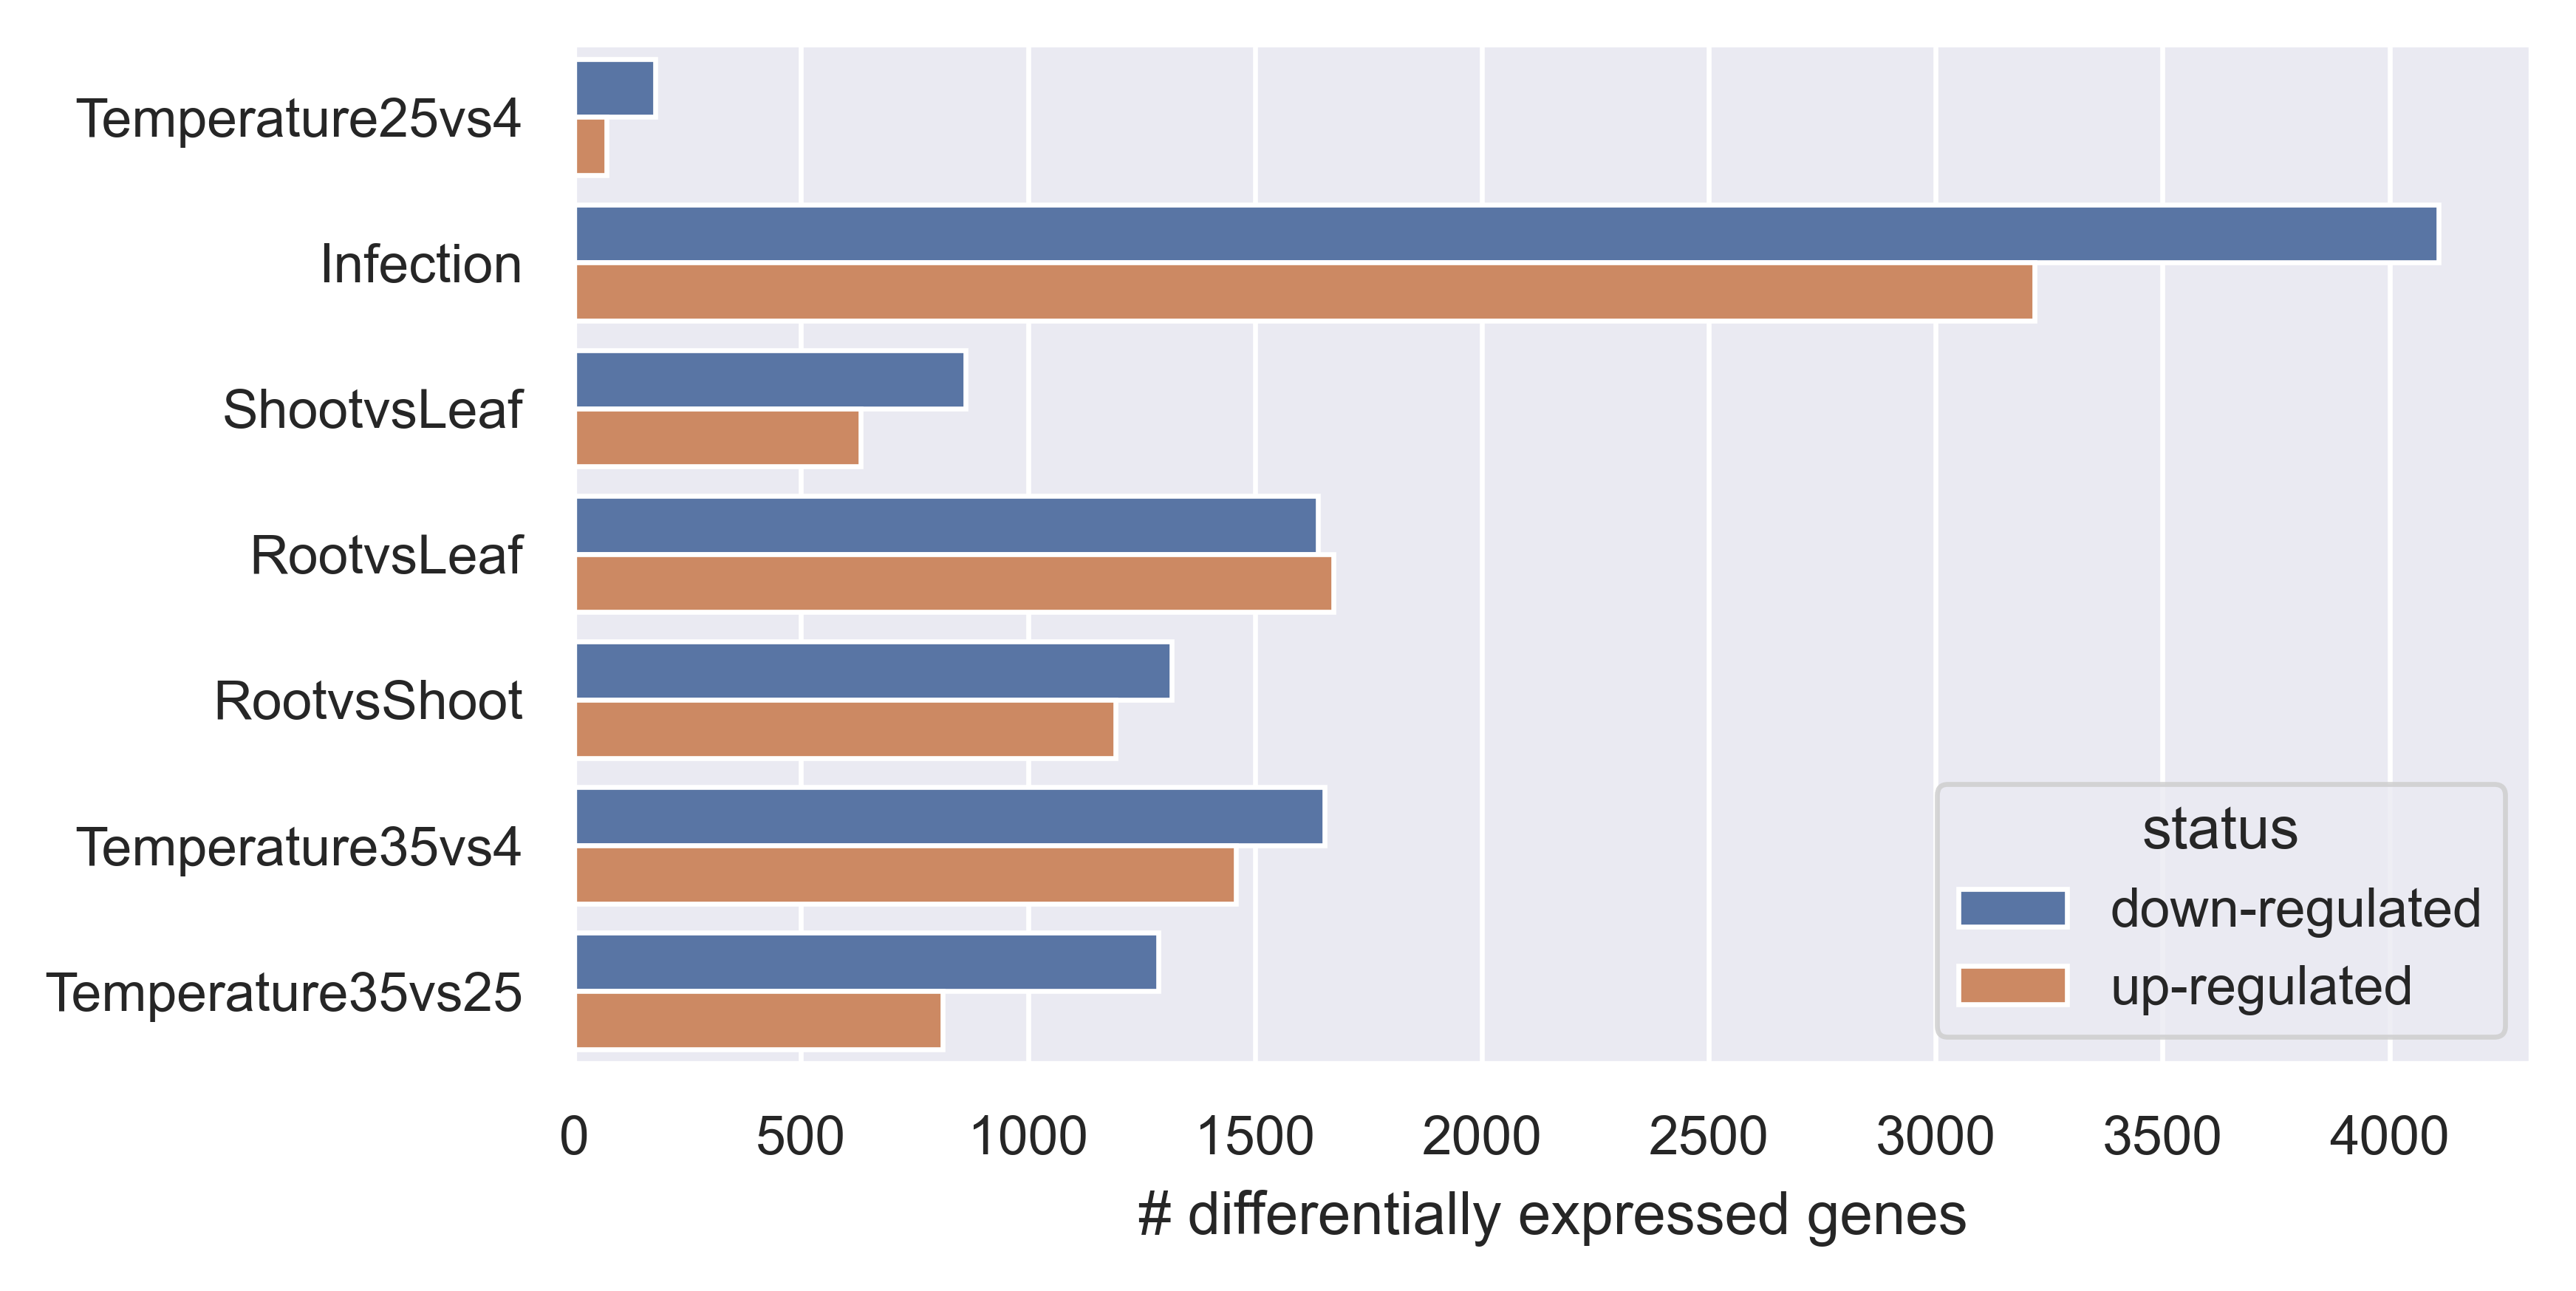

In [6]:
plt.figure(figsize=(5.9, 3), dpi=600)
de_barplot = sns.barplot(
    (
        de_genes
        .filter(pl.col("status") != "not significant")
        .group_by("coef", "status")
        .count()
    ),
    y="coef",
    x="count",
    hue="status",
)
de_barplot.set(xlabel="# differentially expressed genes", ylabel=None)
plt.tight_layout()
plt.savefig("../../pandoc-thesis/figures/rnaseq_de.png")

Methylation analysis - is gene expression correlated with gbm?

In [7]:
cg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict=False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CG").alias("type"),
    )
)

chg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHG").alias("type"),
    )
)

chh_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHH.gff",
        has_header=False,
        separator="\t",
    )
    # Need to account for Helixer gene ids (really wish I fixed this earlier)
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHH").alias("type"),
    )
)

methylation = pl.concat([cg_methylation, chg_methylation, chh_methylation])

# Get average exon methylation per gene
subfeature_methylation = (
    methylation
    # Filter out non-exon/intron features
    .filter(pl.col("column_3").str.contains("exon|intron"))
    .groupby(["gene", "column_3", "type"])
    # Calculate the mean methylation of feature for each gene
    .agg(
        (pl.col("weighted_mean").sum() / pl.col("column_11").sum()).alias("weighted_mean")
    )
    # Pivot so methylation is in columns
    .pivot(index=["gene", "column_3"], columns="type", values="weighted_mean") 
    # Classify genes according as UM, gbM, teM, or ambiguous
    # UM = CG <= 0.05, CHG <= 0.05
    # gbM = CG > 0.2, CHG <=0.05
    # teM = CG > 0.4, CHG > 0.4
    .with_columns(
        (
            pl
            .when((pl.col("CG") <= 0.05) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("UM"))
            .when((pl.col("CG") > 0.2) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("gbM"))
            .when((pl.col("CG") > 0.4) & (pl.col("CHG") > 0.4))
            .then(pl.lit("teM"))
            .otherwise(pl.lit("ambiguous"))
        ).alias("classification")
    )
)

subfeature_methylation.write_csv("../results/subfeature_methylation.csv")

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/2581538231.py:63: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(["gene", "column_3", "type"])


Plot the distribution of gene methylation

<Figure size 3540x1800 with 0 Axes>

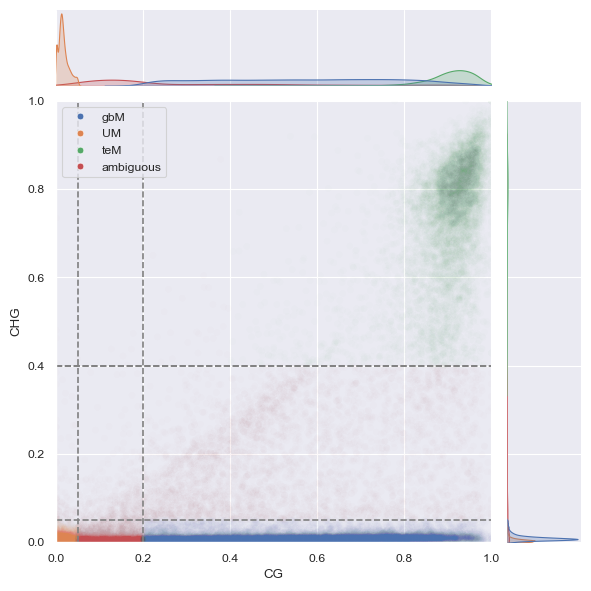

In [8]:
plt.figure(figsize=(5.9, 3), dpi=600)
methylation_scatter = sns.jointplot(
    (
        subfeature_methylation
        .filter(pl.col("column_3") == "exon")
    ),
    x="CG",
    y="CHG",
    hue="classification",
    alpha=0.01,
    xlim=(0, 1),
    ylim=(0, 1),
)

# Need to plot some guides for the cutoffs
plt.axvline(0.05, color="grey", linestyle="--")
plt.axhline(0.05, color="grey", linestyle="--")
plt.axvline(0.2, color="grey", linestyle="--")
plt.axhline(0.4, color="grey", linestyle="--")
plt.axhline(0.4, color="grey", linestyle="--")

# omg matplotlib why is this the way to fix alpha values
for lh in plt.legend().legend_handles:
    lh.set_alpha(1)

plt.savefig("../../pandoc-thesis/figures/methylation_scatterplot.png")

How many genes belong to each methylation category?

In [9]:
(
    subfeature_methylation
    .filter(pl.col("column_3") == "exon")
    .group_by("classification")
    .agg(pl.count("gene").alias("n_genes"))
)

shape: (4, 2)
┌────────────────┬─────────┐
│ classification ┆ n_genes │
│ ---            ┆ ---     │
│ str            ┆ u32     │
╞════════════════╪═════════╡
│ gbM            ┆ 17151   │
│ teM            ┆ 8076    │
│ ambiguous      ┆ 7957    │
│ UM             ┆ 5940    │
└────────────────┴─────────┘

Is gene expression correlated with methylation category?

In [10]:
merged = (
    lcpm
    .join(subfeature_methylation, on="gene", how="left")
)

mod = smf.ols(
    "log_tpm ~ classification",
    data=merged.to_pandas(),
)
res = mod.fit()
print(res.summary())

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/2721669126.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  lcpm


                            OLS Regression Results                            
Dep. Variable:                log_tpm   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                 7.088e+04
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:48:51   Log-Likelihood:            -6.9464e+05
No. Observations:              472728   AIC:                         1.389e+06
Df Residuals:                  472724   BIC:                         1.389e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Plot the gene expression across different tissues n stuff

Classify genes according to their expression category using the following parameters:
* If TPM > 1 and < 1 in tissues, then its tissue-specific
* If TPM > 1 in all tissues, the constitutive
* If < 1, then silent

In [11]:
def classify_expression(list_of_tpm):
    expressed_count, unexpressed_count = 0, 0
    for tpm in list_of_tpm:
        if tpm >= 1:
            expressed_count += 1
        else:
            unexpressed_count += 1
    if expressed_count == len(list_of_tpm):
        return "constitutive"
    if expressed_count == 0:
        return "silent"
    if expressed_count >= 1 & unexpressed_count >= 0:
        return "tissue_specific"

expression_category = (
    lcpm
    .filter(pl.col("condition").str.contains("Leaf|Root|Shoot"))
    # Classify as tissue specific if log_tpm > 1 in one tissue, constituive if log_tpm > 1 in all tissues
    .group_by("gene")
    .agg(pl.col("tpm"))
    .with_columns(
        pl.col("tpm").map_elements(classify_expression).alias("expression_type")
    )
    .select(["gene", "expression_type"])
)

print(expression_category.group_by("expression_type").count())

shape: (3, 2)
┌─────────────────┬───────┐
│ expression_type ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ constitutive    ┆ 22127 │
│ silent          ┆ 9787  │
│ tissue_specific ┆ 3872  │
└─────────────────┴───────┘


/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/189665846.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  .with_columns(
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/189665846.py:27: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(expression_category.group_by("expression_type").count())


/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/3899522019.py:23: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


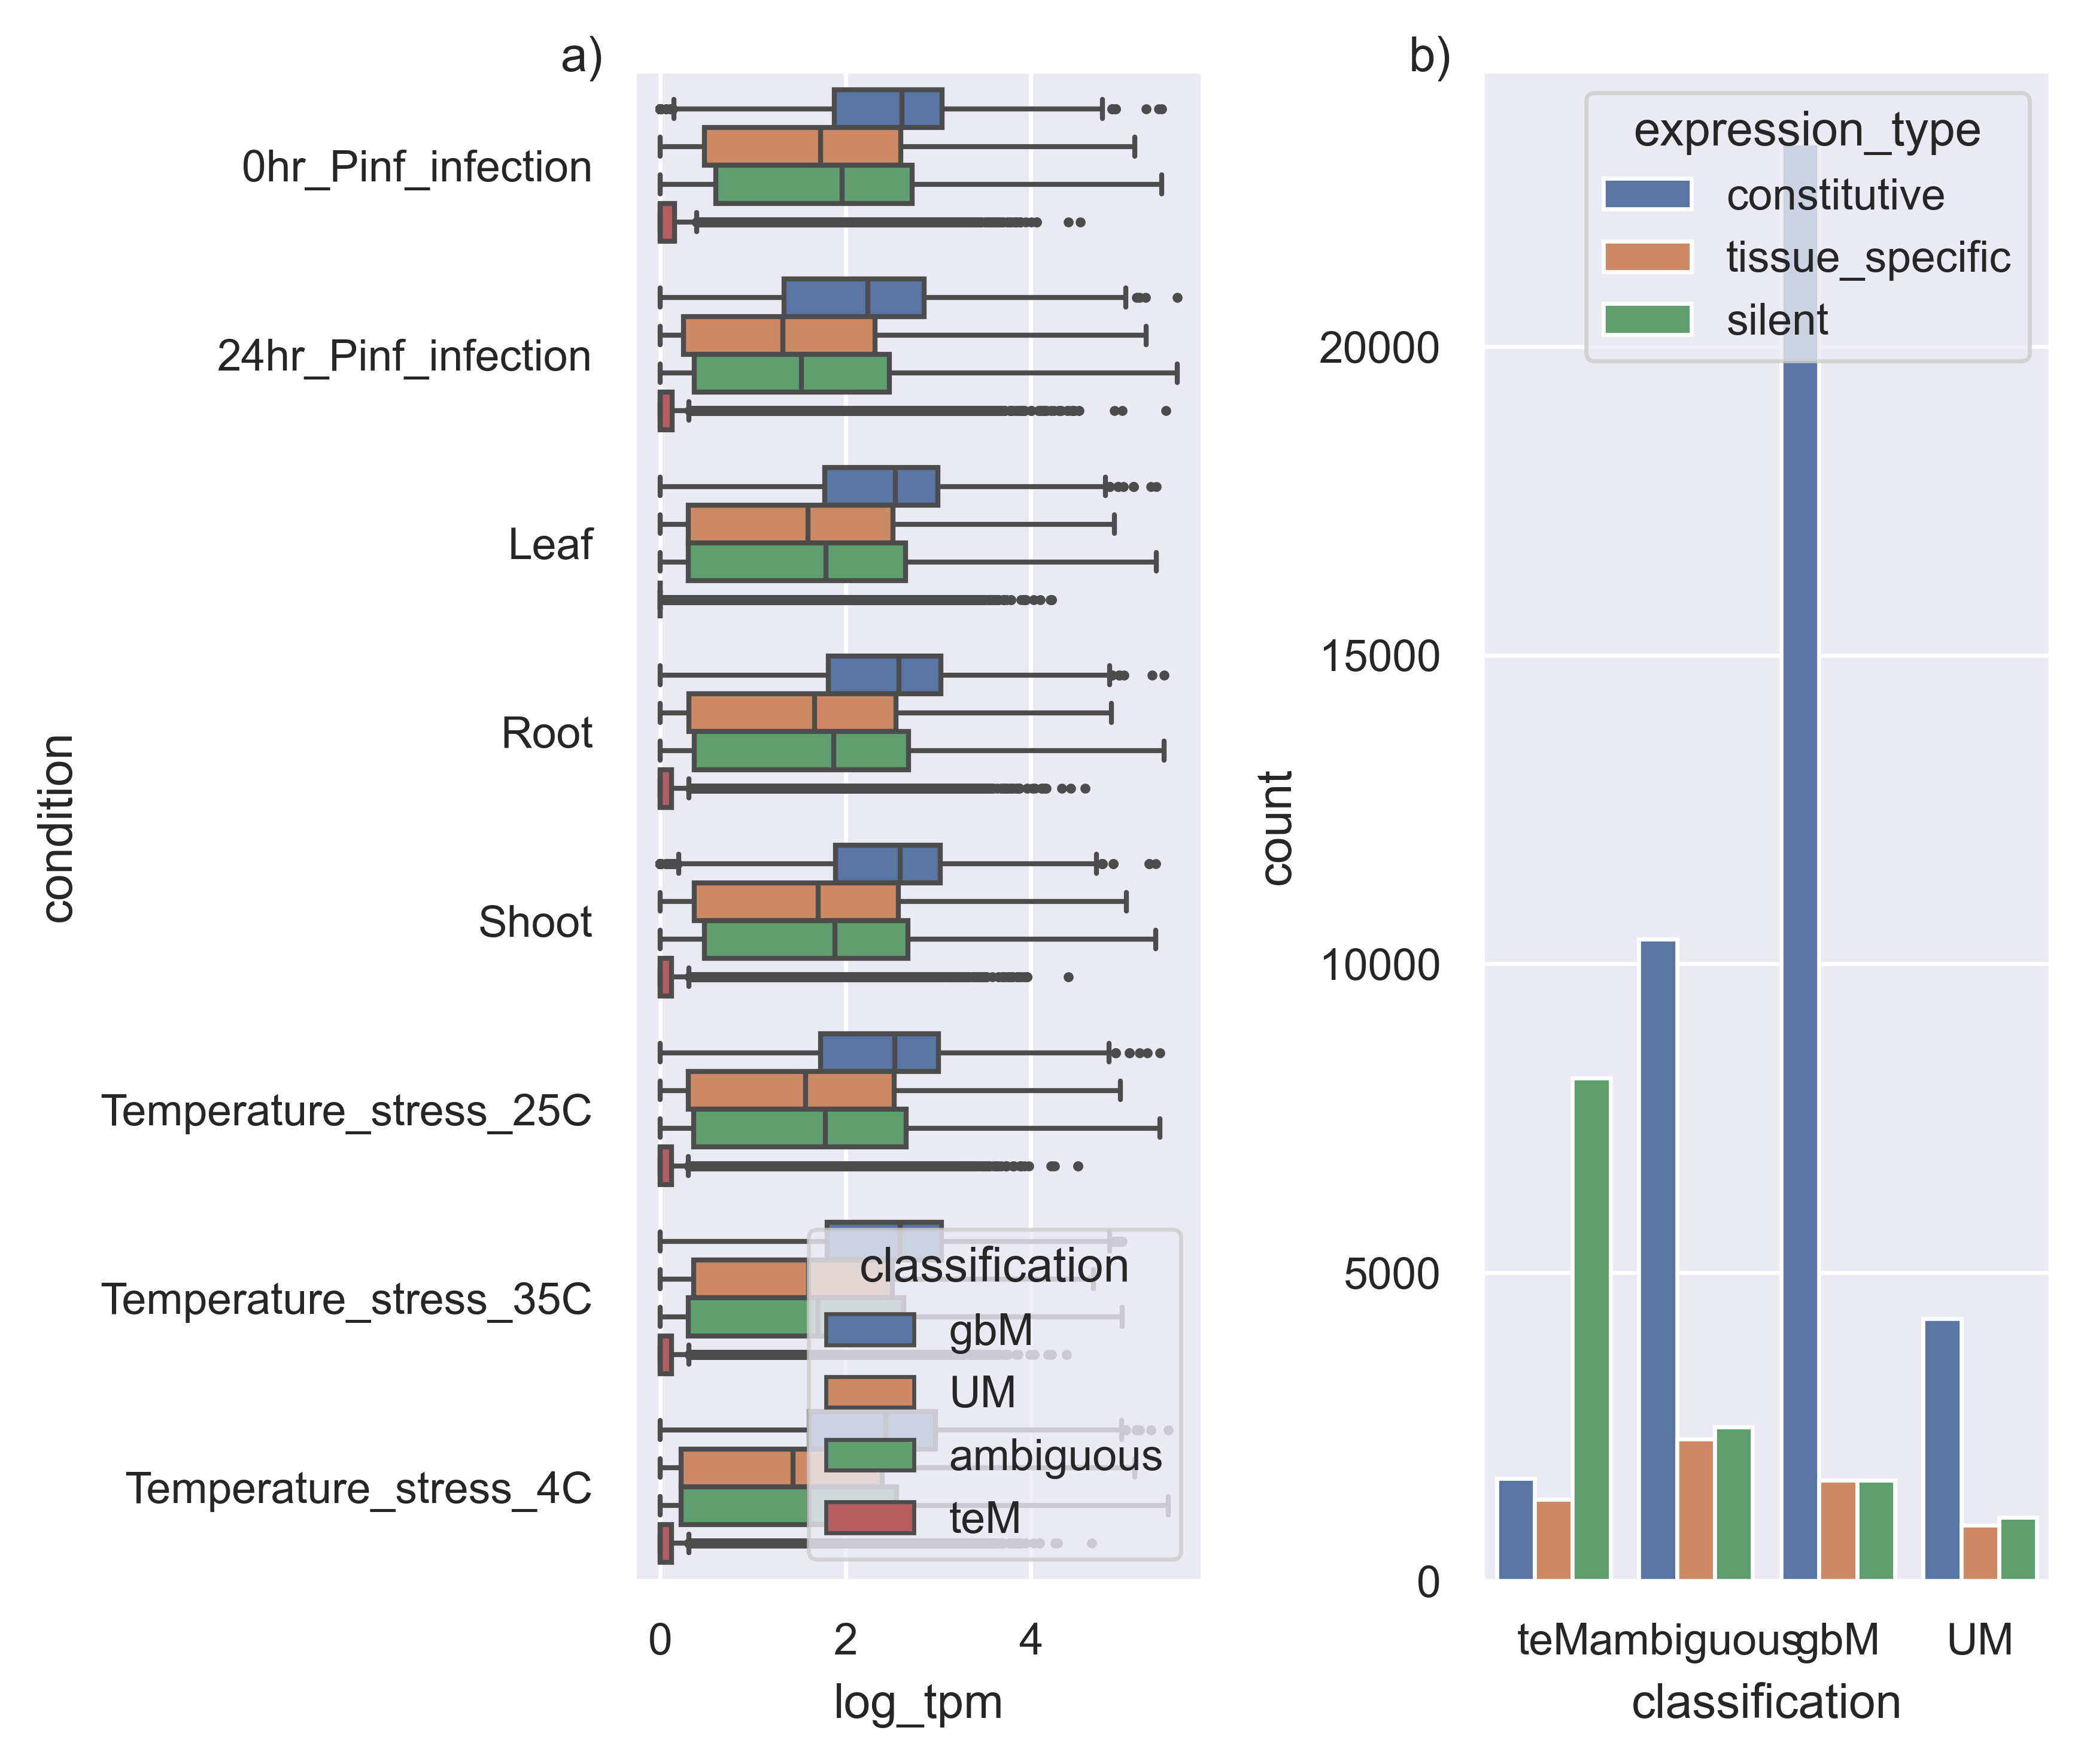

In [12]:
fig, axes = plt.subplots(
    figsize=(5.9, 5),
    ncols=2,
    sharex="col",
    layout="tight",
    dpi=600
)

sns.boxplot(
    merged,
    y="condition",
    x="log_tpm",
    hue="classification",
    fliersize=1,
    ax=axes[0],
)

sns.barplot(
    (
        subfeature_methylation
        .join(expression_category, on = "gene")
        .group_by(["classification", "expression_type"])
        .count()
    ),
    x = "classification",
    y = "count",
    hue = "expression_type",
    ax = axes[1],
)

for n, ax in enumerate(axes):
    ax.text(
        -0.13,
        1,
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

plt.savefig("../../pandoc-thesis/figures/methylation_expression.png")

# Transposable elements

Start by importing all the nencessary data

In [13]:
# get earlgrey family sizes
ids, sizes = [], []
with open("../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum-families.fa.strained") as file:
    for record in SeqIO.parse(file, "fasta"):
        ids.append(record.id)
        sizes.append(len(record.seq))

earlgrey_te_library = pl.DataFrame(
    {
        "id": ids,
        "size": sizes
    }
)

earlgrey_te_library = (
    earlgrey_te_library
    .with_columns(
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1)).alias("family"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 2)).alias("classification"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 3)).alias("subfamily"),
        (pl.lit("earlgrey")).alias("source"),
    )
)

earlgrey_gff = (
    pl.read_csv(
        "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        (pl.col("column_5") - pl.col("column_4")).alias("length"),
    )
    .rename(
        {
            "column_1": "chrom",
            "column_2": "source",
            "column_4": "start",
            "column_5": "end" 
        }
    )
)

earlgrey_coverage = (
    earlgrey_gff
    .group_by("family")
    .agg(pl.sum("length").alias("total_coverage"))
)

ids, sizes = [], []
with open("../results/edta/final_assembly.fa.mod.EDTA.TElib.fa") as file:
    for record in SeqIO.parse(file, "fasta"):
        ids.append(record.id)
        sizes.append(len(record.seq))

edta_te_library = pl.DataFrame(
    {
        "id": ids,
        "size": sizes
    }
)

edta_te_library = (
    edta_te_library
    .with_columns(
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1)).alias("family"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 2)).alias("classification"),
        (pl.col("id").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 3)).alias("subfamily"),
        (pl.lit("edta")).alias("source"),
    )
)

edta_gff = (
    pl.read_csv(
        "../results/edta/final_assembly.fa.mod.EDTA.TEanno.gff3",
        separator="\t",
        has_header=False,
        comment_prefix="#"
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"Name=(.*?);")).alias("family"),
        (pl.col("column_5") - pl.col("column_4")).alias("length")
    )
    .rename(
        {
            "column_1": "chrom",
            "column_2": "source",
            "column_4": "start",
            "column_5": "end" 
        }
    )
)

edta_coverage = (
    edta_gff
    .group_by("family")
    .agg(pl.sum("length").alias("total_coverage"))
)

earlgrey_te_library = (
    earlgrey_te_library
    .join(earlgrey_coverage, on="family", how="left")
)

edta_te_library = (
    edta_te_library
    .join(edta_coverage, on="family", how="left")
)

te_library = pl.concat([earlgrey_te_library, edta_te_library])

# Need to make some sensible TE classification naming suitable for both
# LTR, LINE, SINE, DNA, Helitron, Other, Unknown
# Helitron classifications are at the subfamily level
te_library = (
    te_library
    .with_columns(
        pl.when(pl.col("classification").str.contains("Satellite")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("Simple_repeat")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("snRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("tRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("rRNA")).then(pl.lit("Other"))
        .when(pl.col("classification").str.contains("MITE")).then(pl.lit("Other"))
        .otherwise(pl.col("classification"))
        .alias("neat_classification"),
    )
    .with_columns(
        pl.when(pl.col("subfamily").str.contains("Helitron")).then(pl.col("subfamily"))
        .otherwise(pl.col("neat_classification"))
        .alias("neat_classification"),
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/3076278530.py:102: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  earlgrey_te_library
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/3076278530.py:107: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  edta_te_library


Visualise the differences in transposable element annotations between the EDTA and Earlgrey libraries

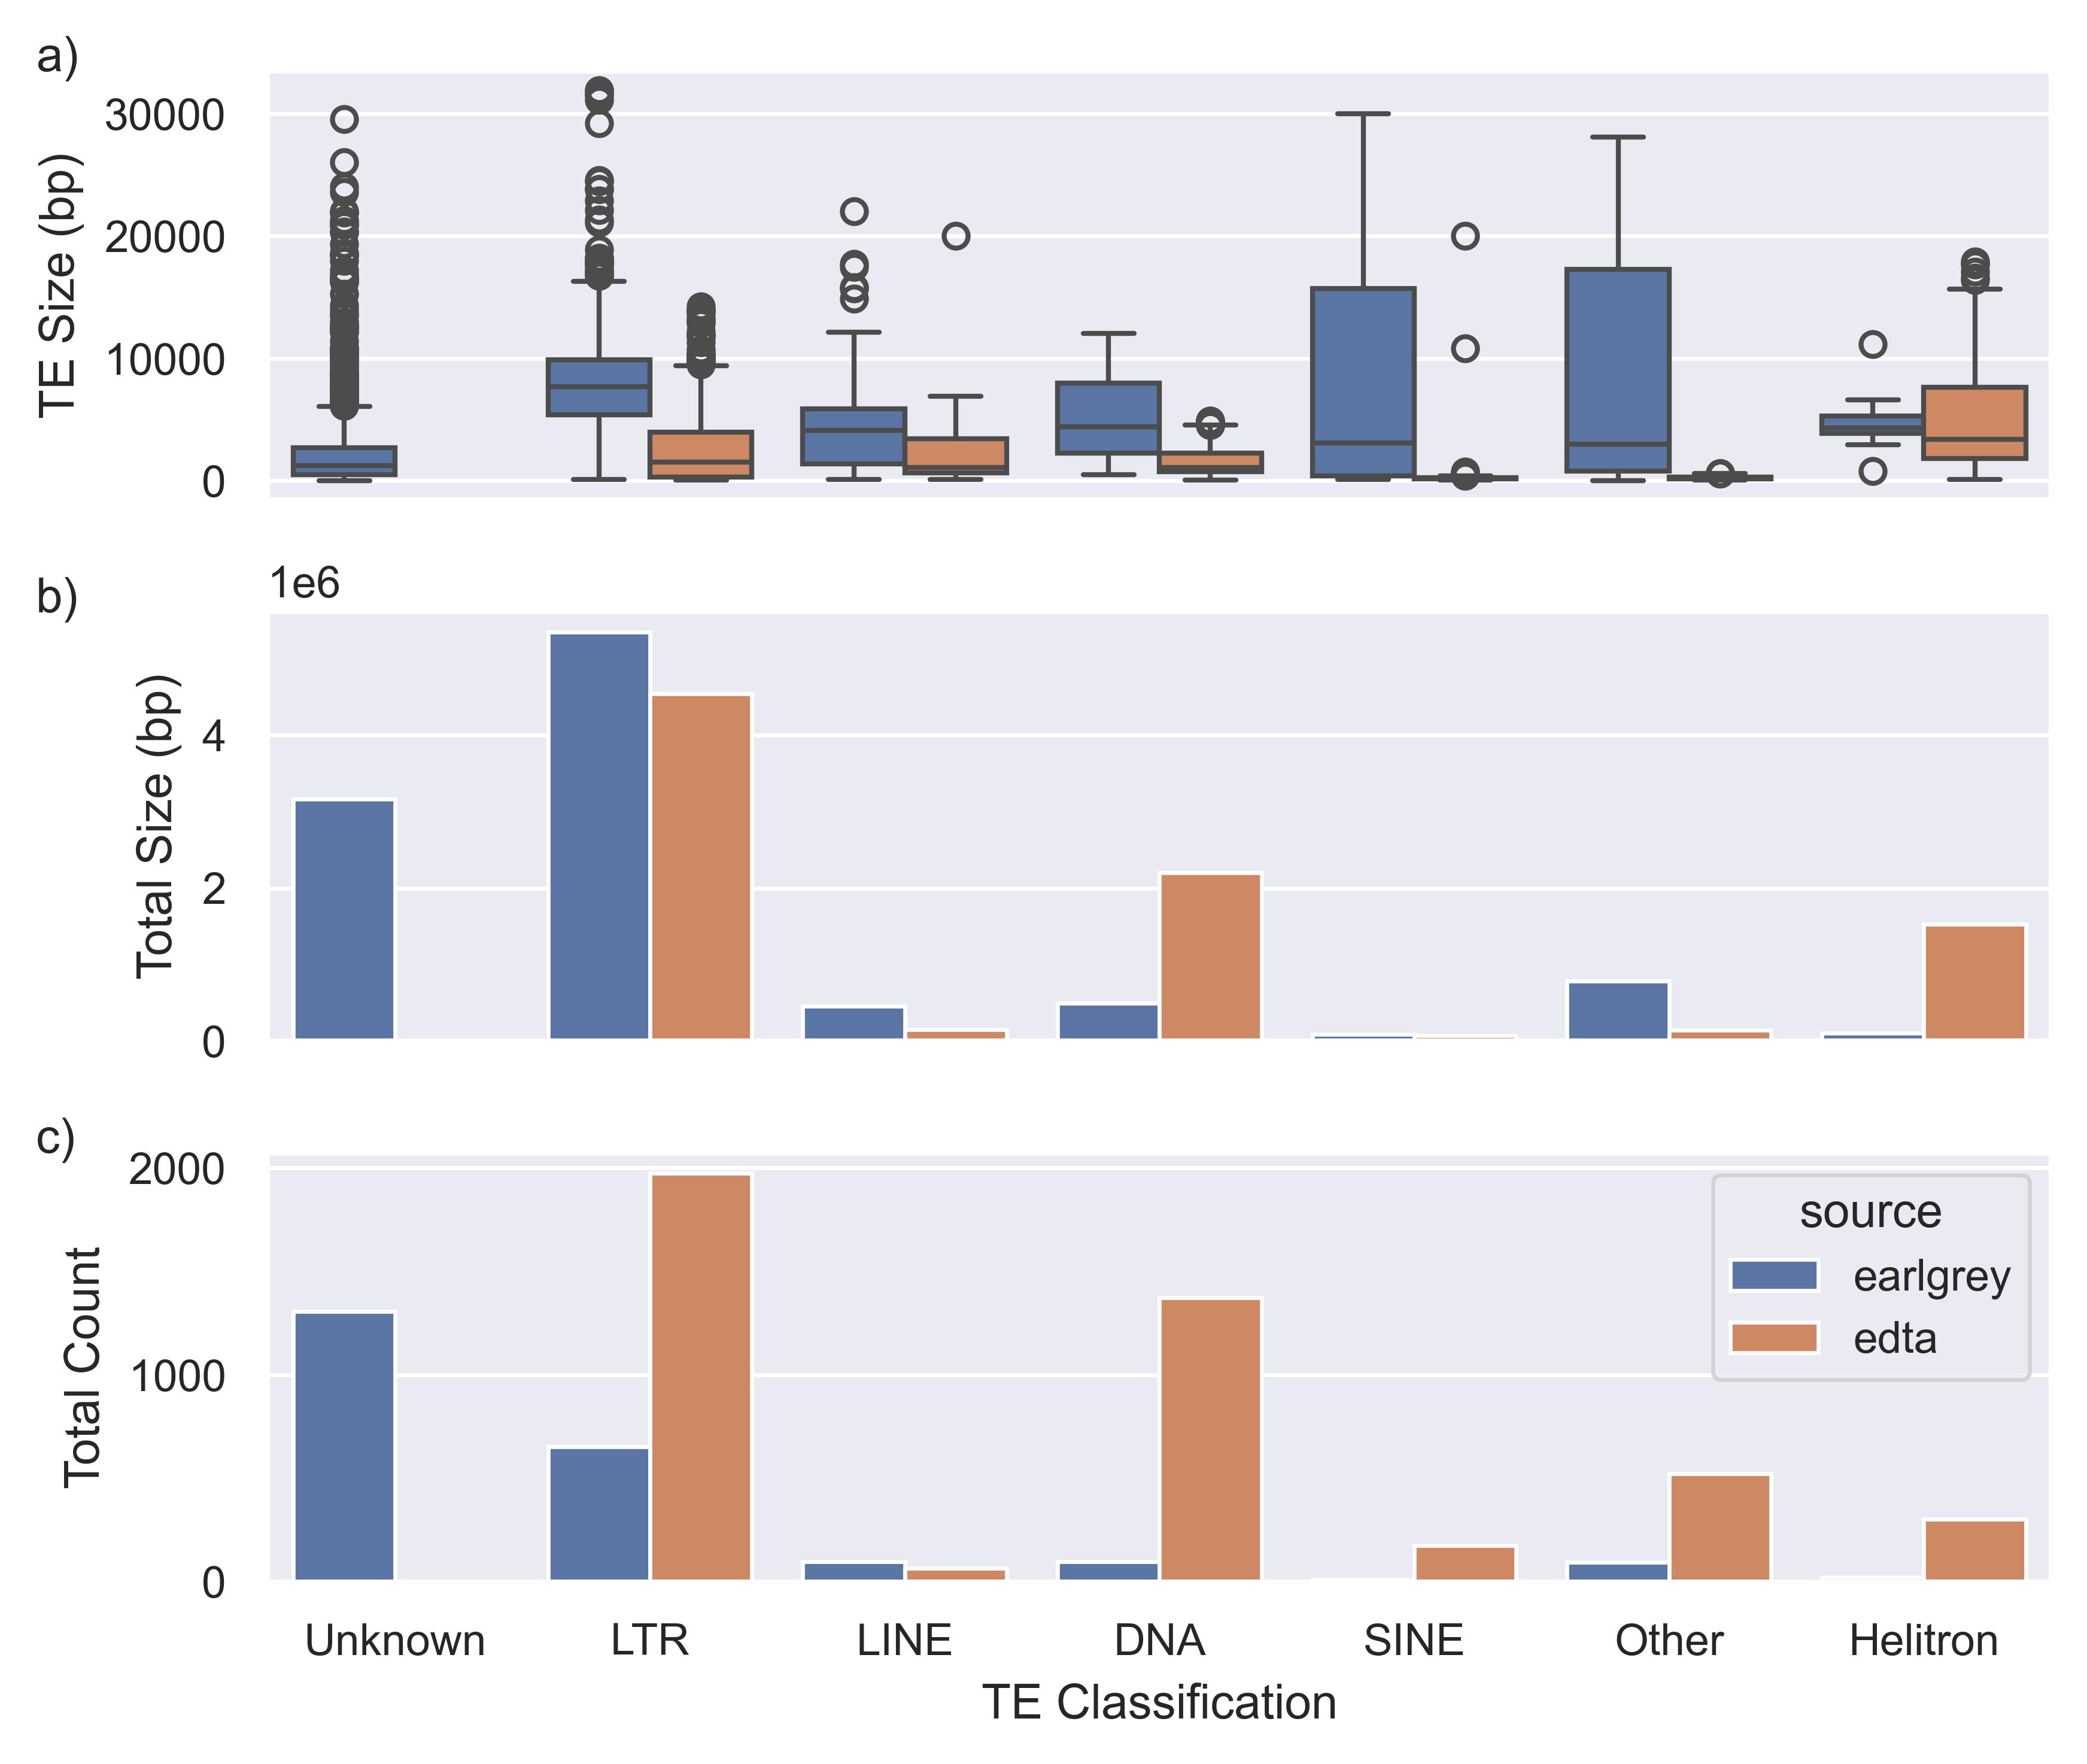

In [14]:
fig, axes = plt.subplots(
    figsize=(5.9, 5),
    nrows=3,
    sharex="col",
    layout="tight",
    dpi=600
)

sns.boxplot(
    te_library.sort("source"),
    x="neat_classification",
    y="size",
    hue="source",
    ax=axes[0],
)

axes[0].set_ylabel("TE Size (bp)")
axes[0].get_legend().remove()

sns.barplot(
    (
        te_library
        .group_by("neat_classification", "source")
        .agg(pl.sum("size").alias("total_size"))
        .sort("source")
    ),
    x="neat_classification",
    y="total_size",
    hue="source",
    ax=axes[1],
)


axes[1].set_ylabel("Total Size (bp)")
axes[1].get_legend().remove()

sns.barplot(
    (
        te_library
        .group_by("neat_classification", "source")
        .agg(pl.count("size").alias("total_count"))
        .sort("source")
    ),
    x="neat_classification",
    y="total_count",
    hue="source",
    ax=axes[2],
)

axes[2].set_ylabel("Total Count")
axes[2].set_xlabel("TE Classification")

for n, ax in enumerate(axes):
    ax.text(
        -0.13,
        1,
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

fig.savefig("../../pandoc-thesis/figures/te_library_comparison.png")


In [15]:
# Import the TEsorter classifications and prep for join
tesorter = (
    pl.read_csv(
        "../results/tesorter/earlgrey.cls.tsv",
        separator="\t",
    )
    .with_columns(pl.col("#TE").str.extract(r"^(.*?)#(.*?)(?:/(.*))?$", 1).alias("family"))
)

# Merge using family IDs
merged = (
    earlgrey_te_library
    .join(tesorter, on="family", how="left")
)

summary = (
    merged
    .group_by("classification", "Clade")
    .agg(pl.count("id").alias("count"), pl.mean("size").alias("mean_size"))
)

print(summary)

shape: (41, 4)
┌────────────────┬─────────┬───────┬─────────────┐
│ classification ┆ Clade   ┆ count ┆ mean_size   │
│ ---            ┆ ---     ┆ ---   ┆ ---         │
│ str            ┆ str     ┆ u32   ┆ f64         │
╞════════════════╪═════════╪═══════╪═════════════╡
│ RC             ┆ unknown ┆ 3     ┆ 7183.0      │
│ Unknown        ┆ CRM     ┆ 1     ┆ 2994.0      │
│ LTR            ┆ Ale     ┆ 48    ┆ 6662.104167 │
│ LINE           ┆ null    ┆ 47    ┆ 4059.297872 │
│ Unknown        ┆ unknown ┆ 74    ┆ 5308.743243 │
│ …              ┆ …       ┆ …     ┆ …           │
│ LTR            ┆ unknown ┆ 52    ┆ 8815.423077 │
│ LTR            ┆ Tekay   ┆ 164   ┆ 9264.414634 │
│ LTR            ┆ Ikeros  ┆ 8     ┆ 5705.625    │
│ LTR            ┆ TAR     ┆ 25    ┆ 6095.92     │
│ LTR            ┆ Tork    ┆ 12    ┆ 5976.0      │
└────────────────┴─────────┴───────┴─────────────┘


/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/3099065814.py:12: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  earlgrey_te_library


## Kimura divergence

Plot the distribution of divergence for TE families and clades of LTRs

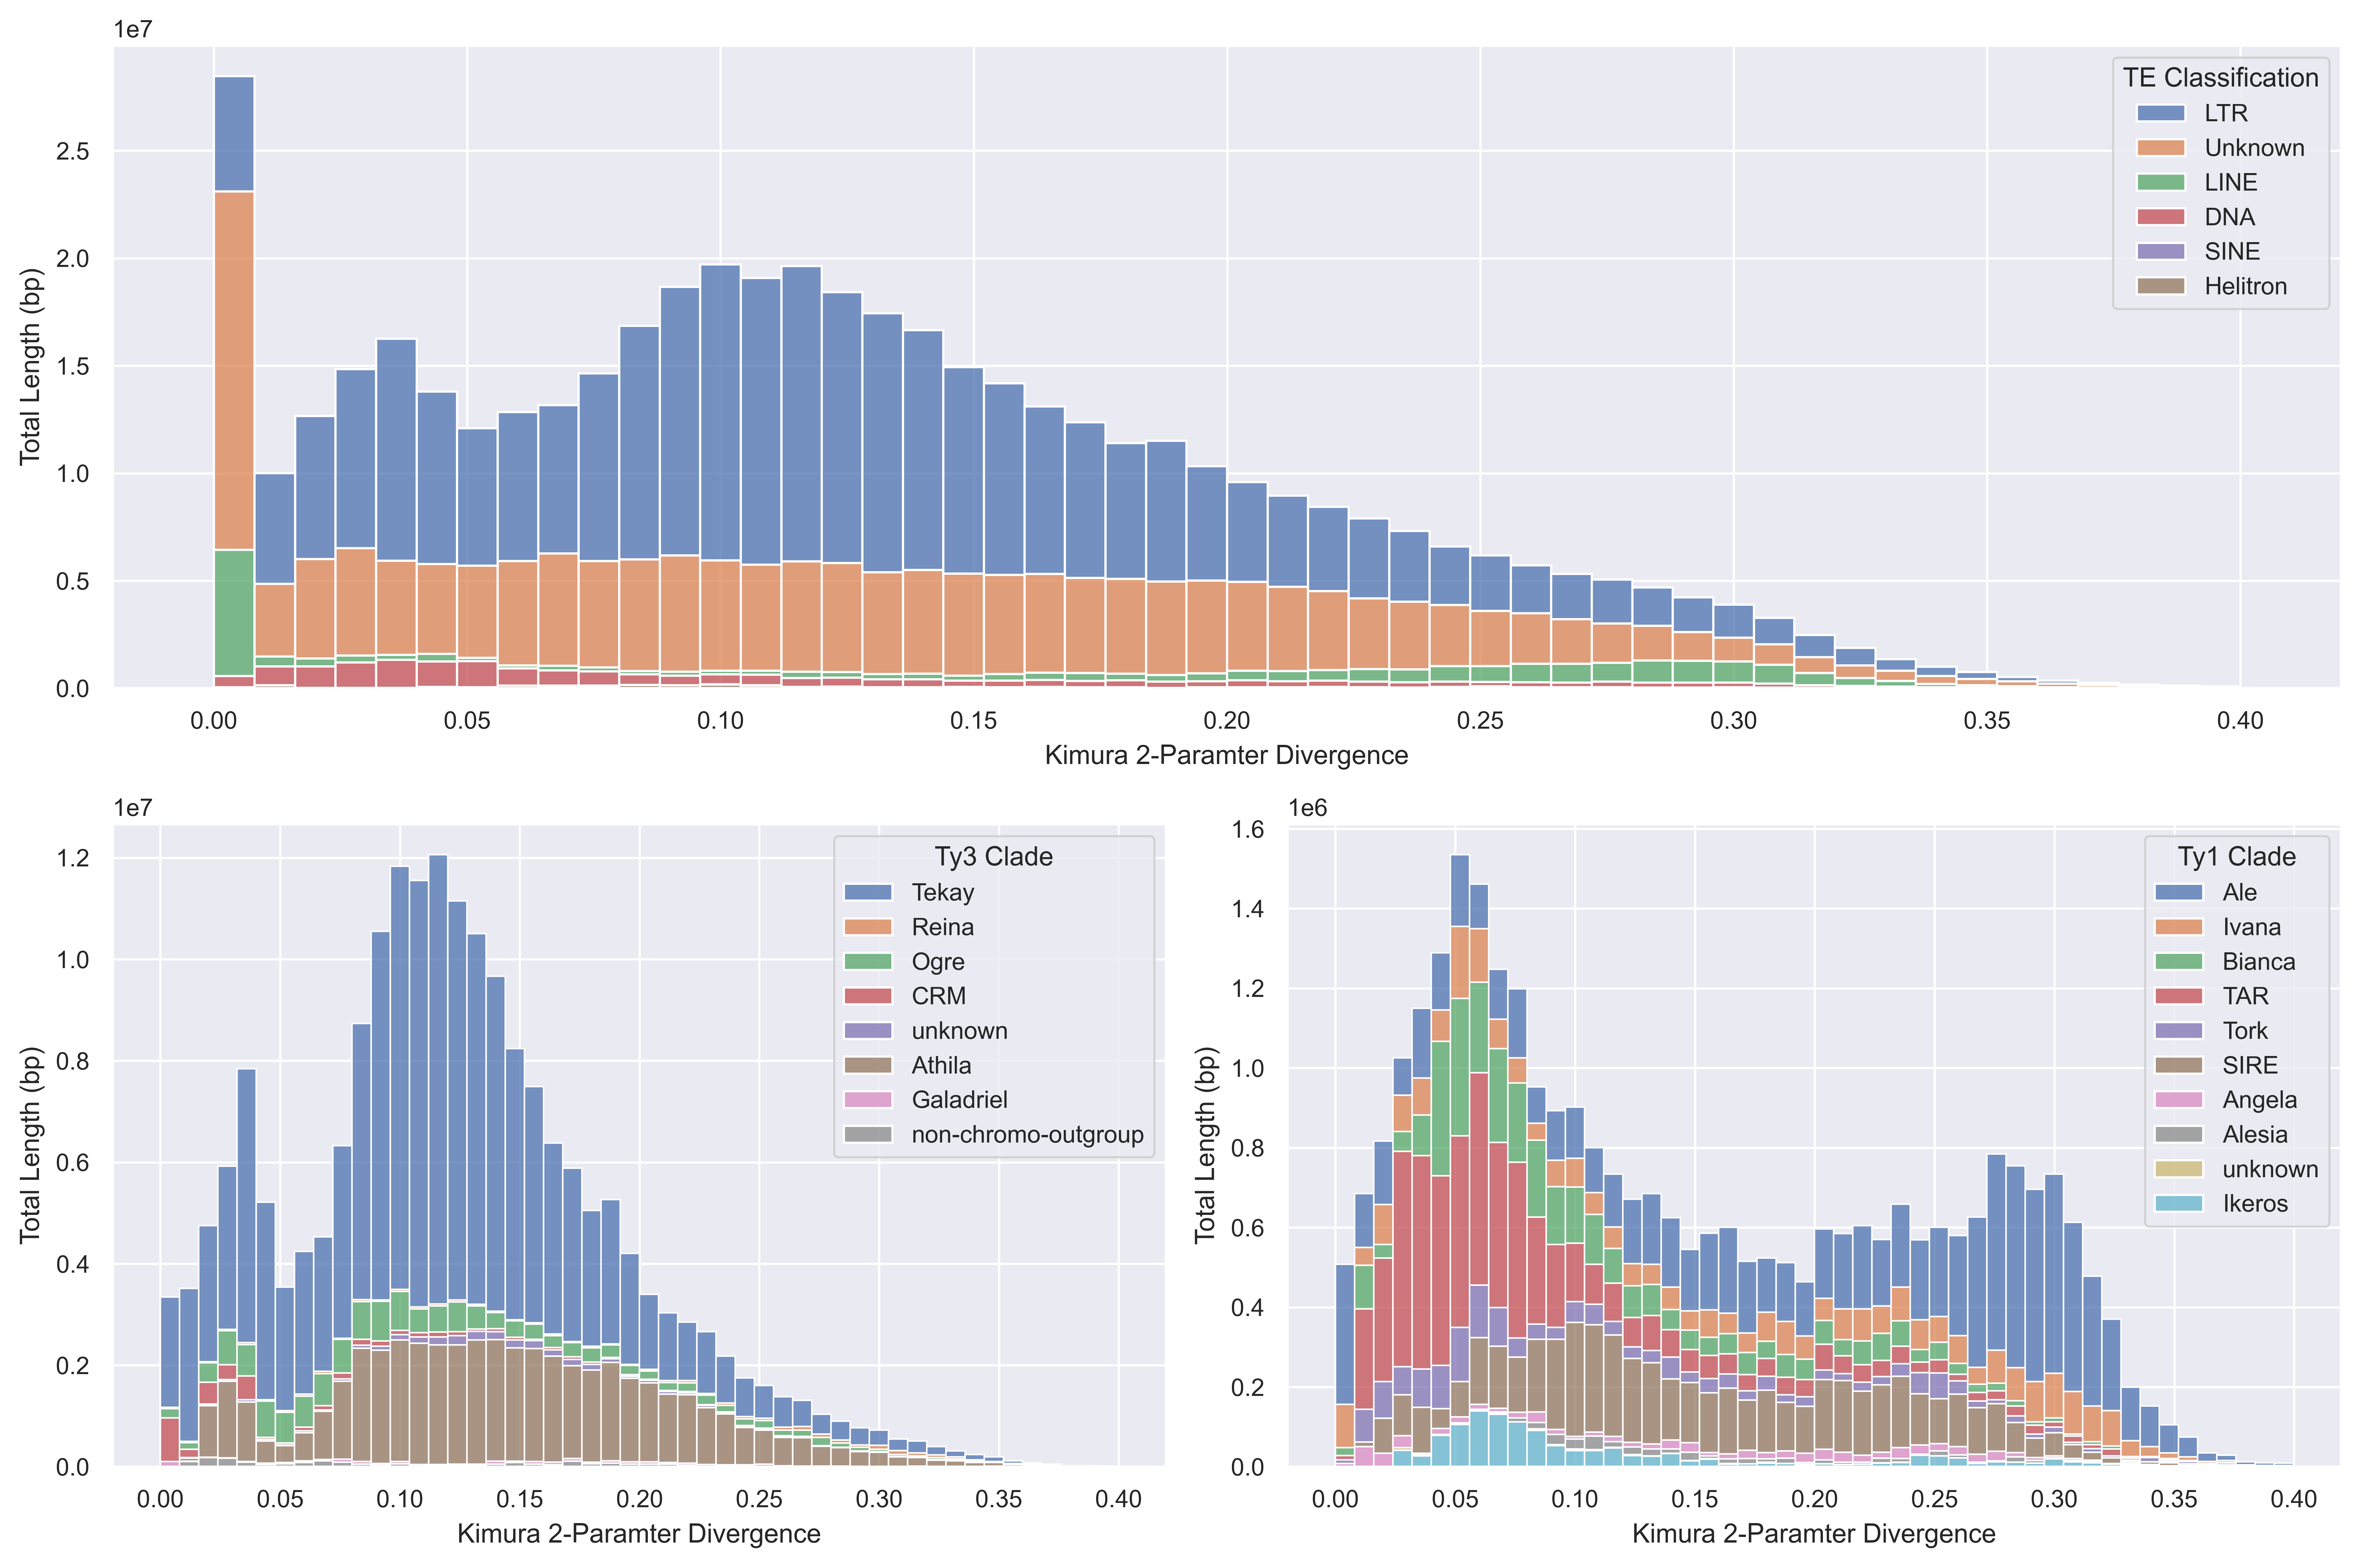

In [16]:
# Load in the gff with kimura distance calculations produced by Earlgrey
divergence_gff = (
    pl.read_csv(
        "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.divergence.gff",
        separator="\t",
        has_header=False,
    )
    .filter(pl.col("column_3").str.contains("LTR|LINE|SINE|DNA|Helitron|Unknown"))
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        (pl.col("column_9").str.extract(r"KIMURA80=(.*?)$")).cast(pl.Float64).alias("divergence"),
        (pl.col("column_5") - pl.col("column_4")).alias("length"),
        (
            pl
            .when(pl.col("column_3").str.contains("LTR"))
            .then(pl.lit("LTR"))
            .when(pl.col("column_3").str.contains("LINE"))
            .then(pl.lit("LINE"))
            .when(pl.col("column_3").str.contains("SINE"))
            .then(pl.lit("SINE"))
            .when(pl.col("column_3").str.contains("DNA"))
            .then(pl.lit("DNA"))
            .when(pl.col("column_3").str.contains("Helitron"))
            .then(pl.lit("Helitron"))
            .when(pl.col("column_3").str.contains("Unknown"))
            .then(pl.lit("Unknown"))
            .alias("neat_classification")
        ),
    )
    .filter((pl.col("divergence").is_not_nan()) & (pl.col("divergence") < 0.4))
)

# Need to make this plot big 'cus legends are huge... maybe just do this regardless for all plots?
fig = plt.figure(figsize=(12, 8), layout="tight", dpi=600)
gs = gridspec.GridSpec(2, 2)

axs = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

sns.histplot(
    divergence_gff,
    x="divergence",
    weights="length",
    hue="neat_classification",
    multiple="stack",
    bins=50,
    ax=axs[0]
)

sns.histplot(
    (
        merged
        .filter(pl.col("Superfamily") == "Gypsy")
        .filter(pl.col("Clade") != "mixture")
        .filter(pl.col("classification").str.contains("LTR"))
        .select(["family", "Clade"])
        .filter(pl.col("Clade") != "NaN")
        .join(divergence_gff, on="family", how="inner")
    ),
    x="divergence",
    weights="length",
    hue="Clade",
    multiple="stack",
    bins=50,
    ax=axs[1]
)

sns.histplot(
    (
        merged
        .filter(pl.col("Superfamily") == "Copia")
        .filter(pl.col("Clade") != "mixture")
        .filter(pl.col("classification").str.contains("LTR"))
        .select(["family", "Clade"])
        .filter(pl.col("Clade") != "NaN")
        .join(divergence_gff, on="family", how="inner")
    ),
    x="divergence",
    weights="length",
    hue="Clade",
    multiple="stack",
    bins=50,
    ax=axs[2]
)

axs[0].set(xlabel="Kimura 2-Paramter Divergence", ylabel="Total Length (bp)")
axs[1].set(xlabel="Kimura 2-Paramter Divergence", ylabel="Total Length (bp)")
axs[2].set(xlabel="Kimura 2-Paramter Divergence", ylabel="Total Length (bp)")
axs[0].legend_.set_title("TE Classification")
axs[1].legend_.set_title("Ty3 Clade")
axs[2].legend_.set_title("Ty1 Clade")

#fig.savefig("../../pandoc-thesis/figures/te_divergence.png")

Calculate the mean methylation profiles across each type of TE.

Only run this on the cluster!! Otherwise laptop will die

In [17]:
# Use the Earlgrey GFF file to translate the keys used by deeptools into something more useful.
#earlgrey_gff = (
#    pl.read_csv(
#        "../results/earlgrey/solanum_verrucosum_EarlGrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
#        separator = "\t",
#        has_header = False
#    )
#    .with_columns(
#        [
#            (pl.concat_str(
#                pl.col("column_1"),
#                pl.concat_str(
#                    pl.col("column_4"),
#                    pl.col("column_5"),
#                    separator = "-"
#                ),
#                separator = ":")
#            .alias("id")),
#            (pl.col("column_9").str.extract(r"ID=(.*?);").alias("family"))
#        ]
#    )
#    .select(["id", "family", "column_3"])
#)
#
#new_column_names = ["id"] + [f"{type}:{i}" for type in ["CG", "CHG", "CHH"] for i in range(1,601)]
#
#methylation_df = pl.read_csv(
#    "../results/deepsignal/te_matrix.tab",
#    separator = "\t",
#    comment_prefix = "@",
#    has_header = False
#)
#
#methylation_df = methylation_df.drop("column_1", "column_2", "column_3", "column_5", "column_6")
#methylation_df = methylation_df.rename(dict(zip(methylation_df.columns, new_column_names)))
#
## Join datasets
#methylation_df = methylation_df.join(earlgrey_gff, on = "id", how = "inner")
#
## Convert to long format
#methylation_df = methylation_df.melt(id_vars = ["id", "family", "column_3"], variable_name = "position", value_name = "methylation")
#
## Split the position column into two columns
#methylation_df = methylation_df.with_columns([
#    pl.col("position")
#    .str.split_exact(":", 1)
#    .struct.rename_fields(["type", "Position"])
#    .alias("fields"),
#    ]
#).unnest("fields")
#
#summary_df = (
#    methylation_df.select(
#        pl.col("column_3").alias("te_type"),
#        pl.col("type"),
#        pl.col("Position").cast(pl.Int32),
#        pl.col("methylation").cast(pl.Float32)
#    )
#    .group_by(["te_type", "type", "Position"])
#    .agg(pl.col("methylation").drop_nans().mean())
#)
#
#summary_df.write_csv("../results/te_methylation_summary.csv")
#
## Calculate the mean body methylation for each family
#body_methylation_df = (
#    methylation_df.select(
#        pl.col("family"),
#        pl.col("type"),
#        pl.col("Position").cast(pl.Int32),
#        pl.col("methylation").cast(pl.Float32)
#    )
#    .filter((pl.col("Position") >= 200) & (pl.col("Position") < 400))
#    .group_by(["family", "type"])
#    .agg(pl.col("methylation").drop_nans().mean())
#)
#
#body_methylation_df.write_csv("../results/te_body_methylation_summary.csv")
#
#annotation_methylation = (
#    methylation_df
#    .with_columns(pl.col("methylation").cast(pl.Float32))
#    .group_by("id", "type", "family")
#    .agg(pl.col("methylation").drop_nans().mean())
#)
#
#annotation_methylation.write_csv("../results/te_body_annotation_methylation_summary.csv")


Plot the methylation profiles for TEs

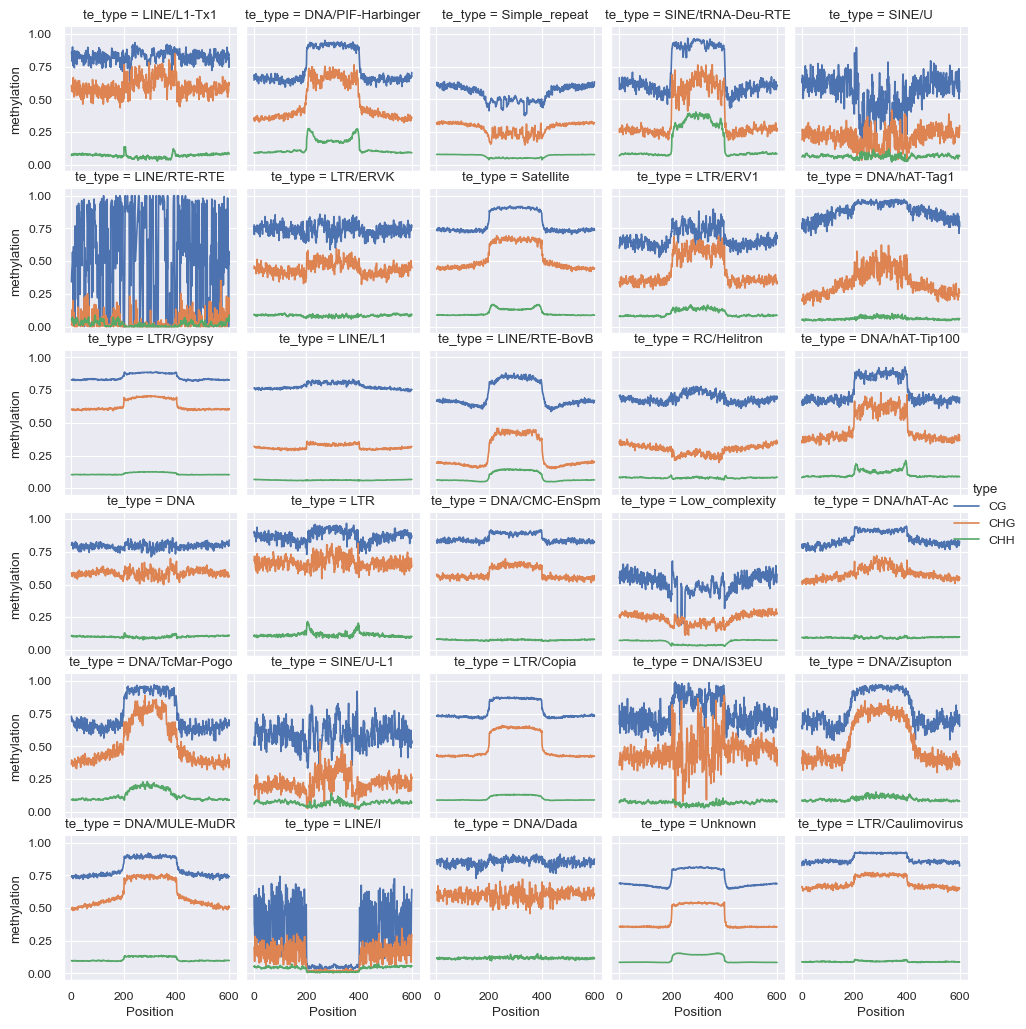

In [50]:
summary_df = pl.read_csv("../results/te_methylation_summary.csv")

plot = sns.FacetGrid(
    summary_df,
    col = "te_type",
    col_wrap = 5,
    hue="type",
)
plot.map_dataframe(
    sns.lineplot,
    x="Position",
    y="methylation",
)

plot.add_legend()

plot.figure.set_size_inches(10, 10)
plot.savefig(
    "../../pandoc-thesis/figures/te_methylation_profile.png",
    
)

Identify centromere biased transposable element families

In [19]:
# Find earlgrey TEs that lie inside the centromeres

centromeres = (
    pl.read_csv(
        "../results/cenh3/centromeres.bed",
        separator="\t",
        has_header=False,
    )
    .select(
        chrom="column_1",
        start="column_2",
        end="column_3",
    )
)

earlgrey_intersecting = (
    earlgrey_gff.join(centromeres, on="chrom", how="inner")
    .with_columns(
        ((pl.col("start") > pl.col("start_right")) &
        (pl.col("end") < pl.col("end_right")))
        .alias("inside_centromere")
    )
)

pivoted = (
    earlgrey_intersecting
    .group_by(["family", "inside_centromere"]).count()
    .pivot(
        values="count",
        index="family",
        columns="inside_centromere",
        aggregate_function="first",
    )
    .fill_null(0)
    .with_columns(
        (pl.col("true") + pl.col("false")).alias("total"),
    )
)

total_inside = pivoted.select(pl.col("true")).sum().item()
total_outside = pivoted.select(pl.col("false")).sum().item()

results = []
for row in pivoted.iter_rows(named=True):
    contingency_table = [
        [row["true"], row["false"]],
        [total_inside - row["true"], total_outside - row["false"]],
    ]

    odds_ratio, p_value = fisher_exact(contingency_table)

    results.append(
        {
            "family": row["family"],
            "odds_ratio": odds_ratio,
            "p_value": p_value,
        }
    )

centromere_bias = pl.DataFrame(results)

centromere_bias.write_csv("../results/earlgrey_centromere_enrichment.csv")

print(centromere_bias)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/1755838596.py:27: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .group_by(["family", "inside_centromere"]).count()


shape: (7_944, 3)
┌────────────────────┬────────────┬──────────┐
│ family             ┆ odds_ratio ┆ p_value  │
│ ---                ┆ ---        ┆ ---      │
│ str                ┆ f64        ┆ f64      │
╞════════════════════╪════════════╪══════════╡
│ (agttc)n           ┆ 28.583992  ┆ 0.045322 │
│ rnd-5_family-18727 ┆ 0.0        ┆ 0.058273 │
│ rnd-5_family-69    ┆ 2.271861   ┆ 0.105467 │
│ rnd-1_family-219   ┆ 9.527931   ┆ 0.109482 │
│ rnd-1_family-490   ┆ 0.0        ┆ 1.0      │
│ …                  ┆ …          ┆ …        │
│ (atagtaa)n         ┆ 0.0        ┆ 1.0      │
│ (gtggca)n          ┆ 0.0        ┆ 1.0      │
│ rnd-5_family-6926  ┆ 0.0        ┆ 1.0      │
│ (atgtca)n          ┆ 0.0        ┆ 1.0      │
│ (gagc)n            ┆ 0.0        ┆ 1.0      │
└────────────────────┴────────────┴──────────┘


Plot centromere bias odds distribution

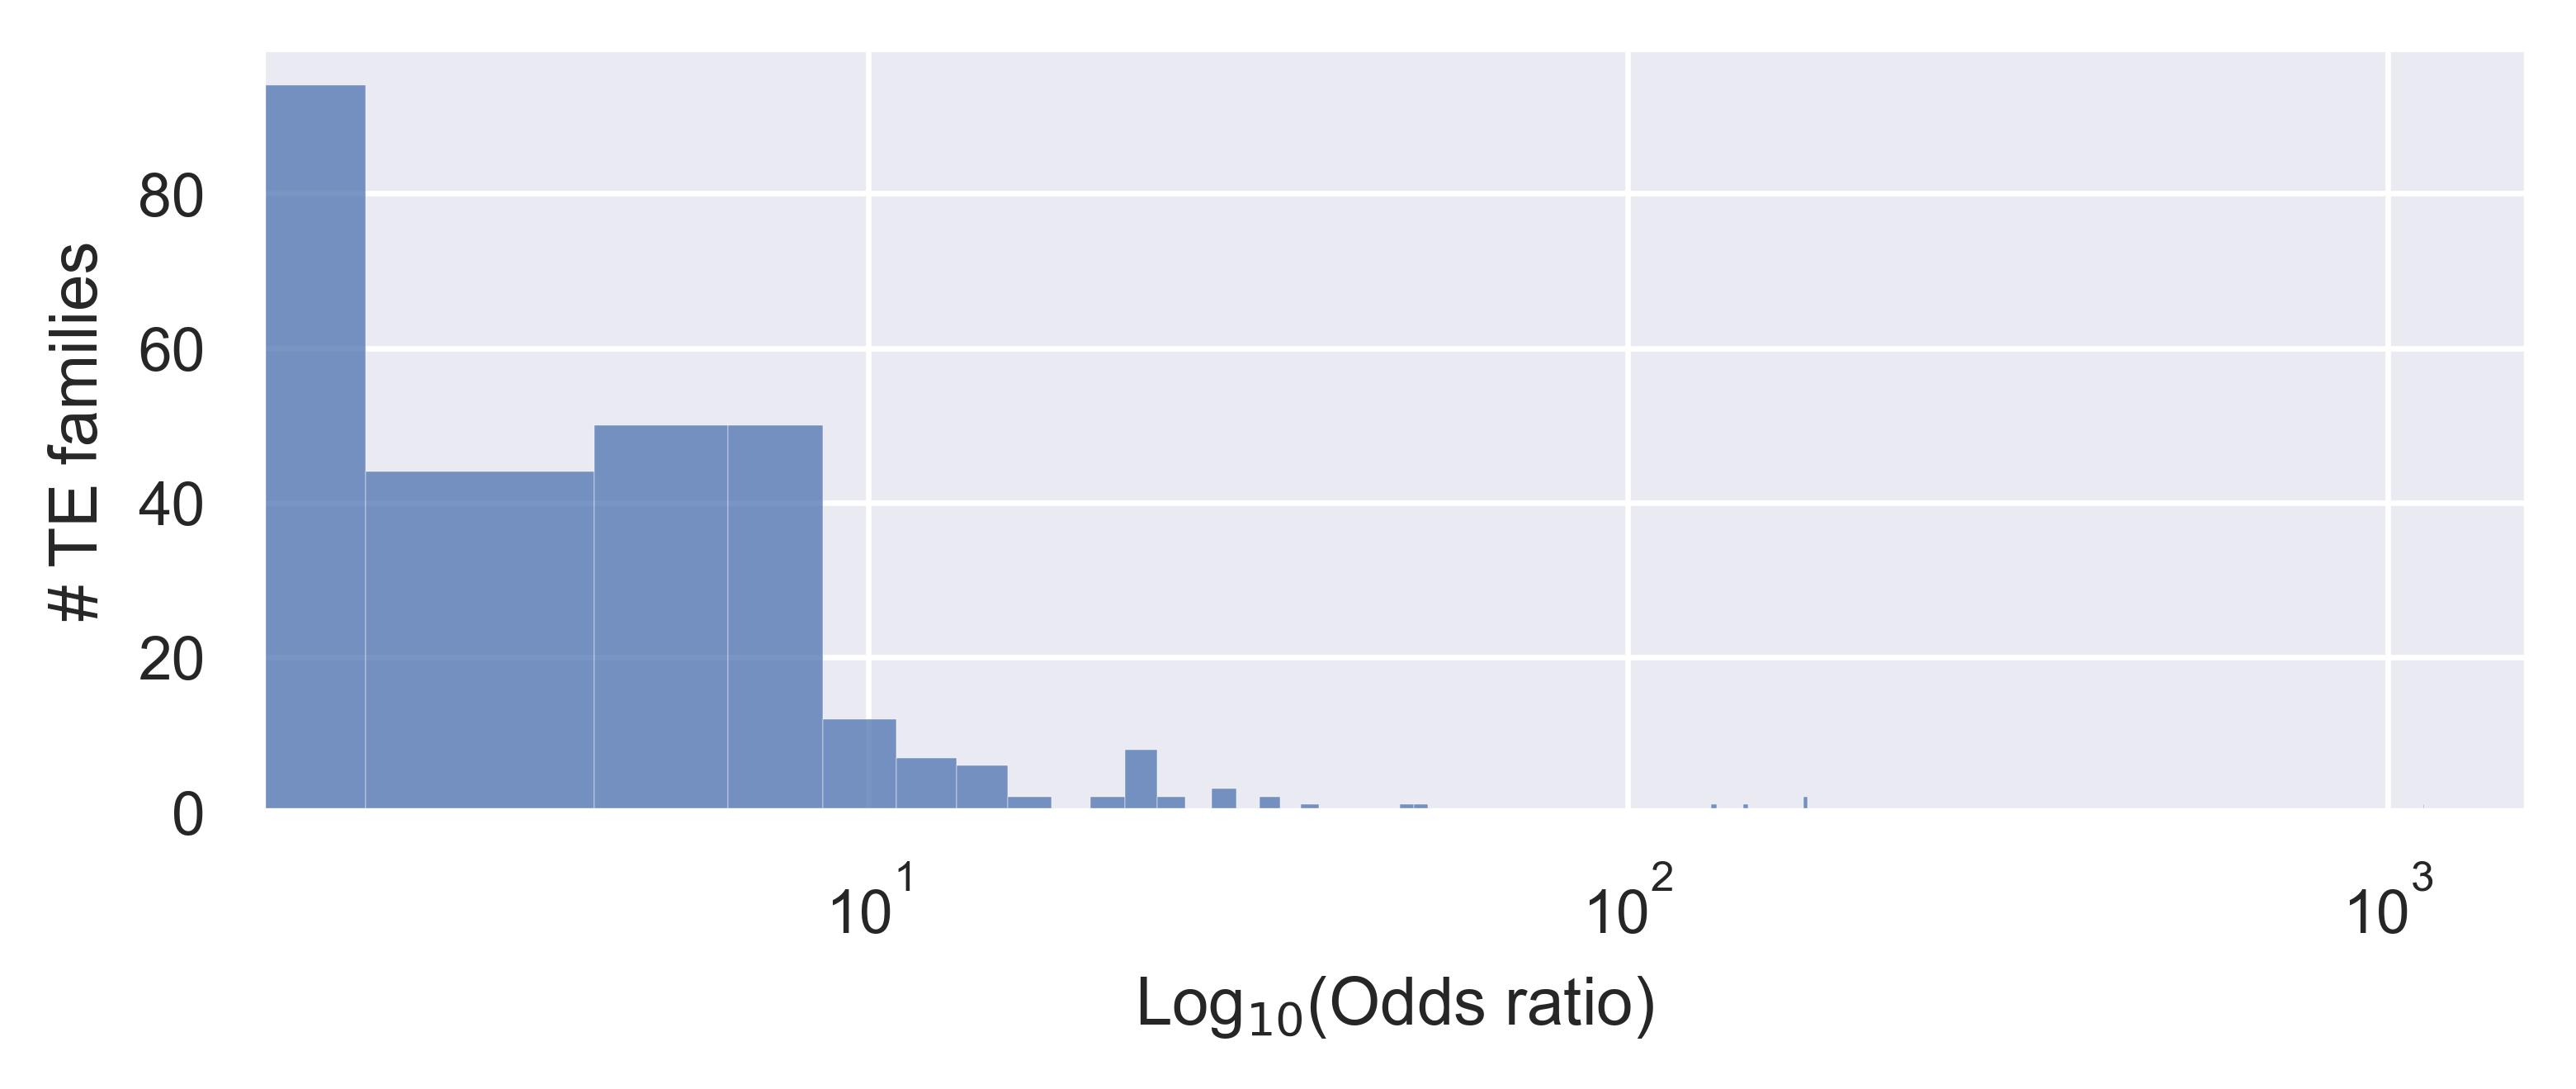

In [20]:
plt.figure(figsize=(5.9, 2), dpi=600)
sns.histplot(
    (
        centromere_bias
        .filter((pl.col("p_value") < 0.001))
    ),
    x="odds_ratio",
)
plt.xscale("log")
plt.xlabel("Log$_{10}$(Odds ratio)")
plt.ylabel("# TE families")
plt.savefig(
    "../../pandoc-thesis/figures/earlgrey_centromere_bias_dist.png",
)

Lets use 10 as a cutoff for centromere-bias

In [21]:
display(
    centromere_bias
    .join((earlgrey_te_library.select("family", "subfamily").unique()), on="family", how="inner")
    .filter((pl.col("p_value") < 0.05) & (pl.col("odds_ratio") > 10))
    .group_by("subfamily")
    .agg(
        pl.col("family").count().alias("count"),
    )
)

shape: (4, 2)
┌──────────────┬───────┐
│ subfamily    ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ L1-Tx1       ┆ 1     │
│ Gypsy        ┆ 26    │
│ null         ┆ 23    │
│ Caulimovirus ┆ 2     │
└──────────────┴───────┘

Mostly Ty3 elements

In [22]:
centromere_bias_tesorter = (
    centromere_bias
    .filter((pl.col("p_value") < 0.05) & (pl.col("odds_ratio") > 10))
    .join(tesorter, on="family", how="inner")
    .select("#TE", "odds_ratio", "p_value", "Order", "Clade", "Complete")
    .sort("odds_ratio", descending=True)
)

#with pl.Config() as cfg, open("../../pandoc-thesis/figures/tesorter_centromeres.txt", "w") as f:
#    cfg.set_tbl_formatting("ASCII_HORIZONTAL_ONLY")
#    cfg.set_tbl_hide_column_data_types(True)
#    cfg.set_tbl_rows(-1)
#    print(tesorted_results, file=f)

(
    centromere_bias_tesorter
    .group_by("Clade")
    .agg(pl.count())
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/2463573939.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count())


shape: (4, 2)
┌─────────┬───────┐
│ Clade   ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ Athila  ┆ 3     │
│ CRM     ┆ 13    │
│ Tekay   ┆ 17    │
│ unknown ┆ 3     │
└─────────┴───────┘

## Now look at CENH3 mapping of these

In [23]:
# ONLY RUN ON CLUSTER MY LAPTOP CAN'T HANDLE THIS
#
#q1 = (
#    pl.scan_csv(
#        "../results/cenh3/earlgrey_cenh3.bed",
#        separator="\t",
#        has_header=False,
#    )
#    .with_columns(
#        pl.col("column_9").str.extract(r"ID=(.*?);").alias("ID"),
#    )
#    .select(["ID", "column_3", "column_11"])
#    .group_by("ID", "column_3")
#    .agg(pl.mean("column_11").alias("sum"))
#)
#
#earlgrey_cenh3 = q1.collect(streaming=True)
#
#earlgrey_cenh3.write_csv("../results/earlgrey_cenh3_summary.csv")

Plot distribution

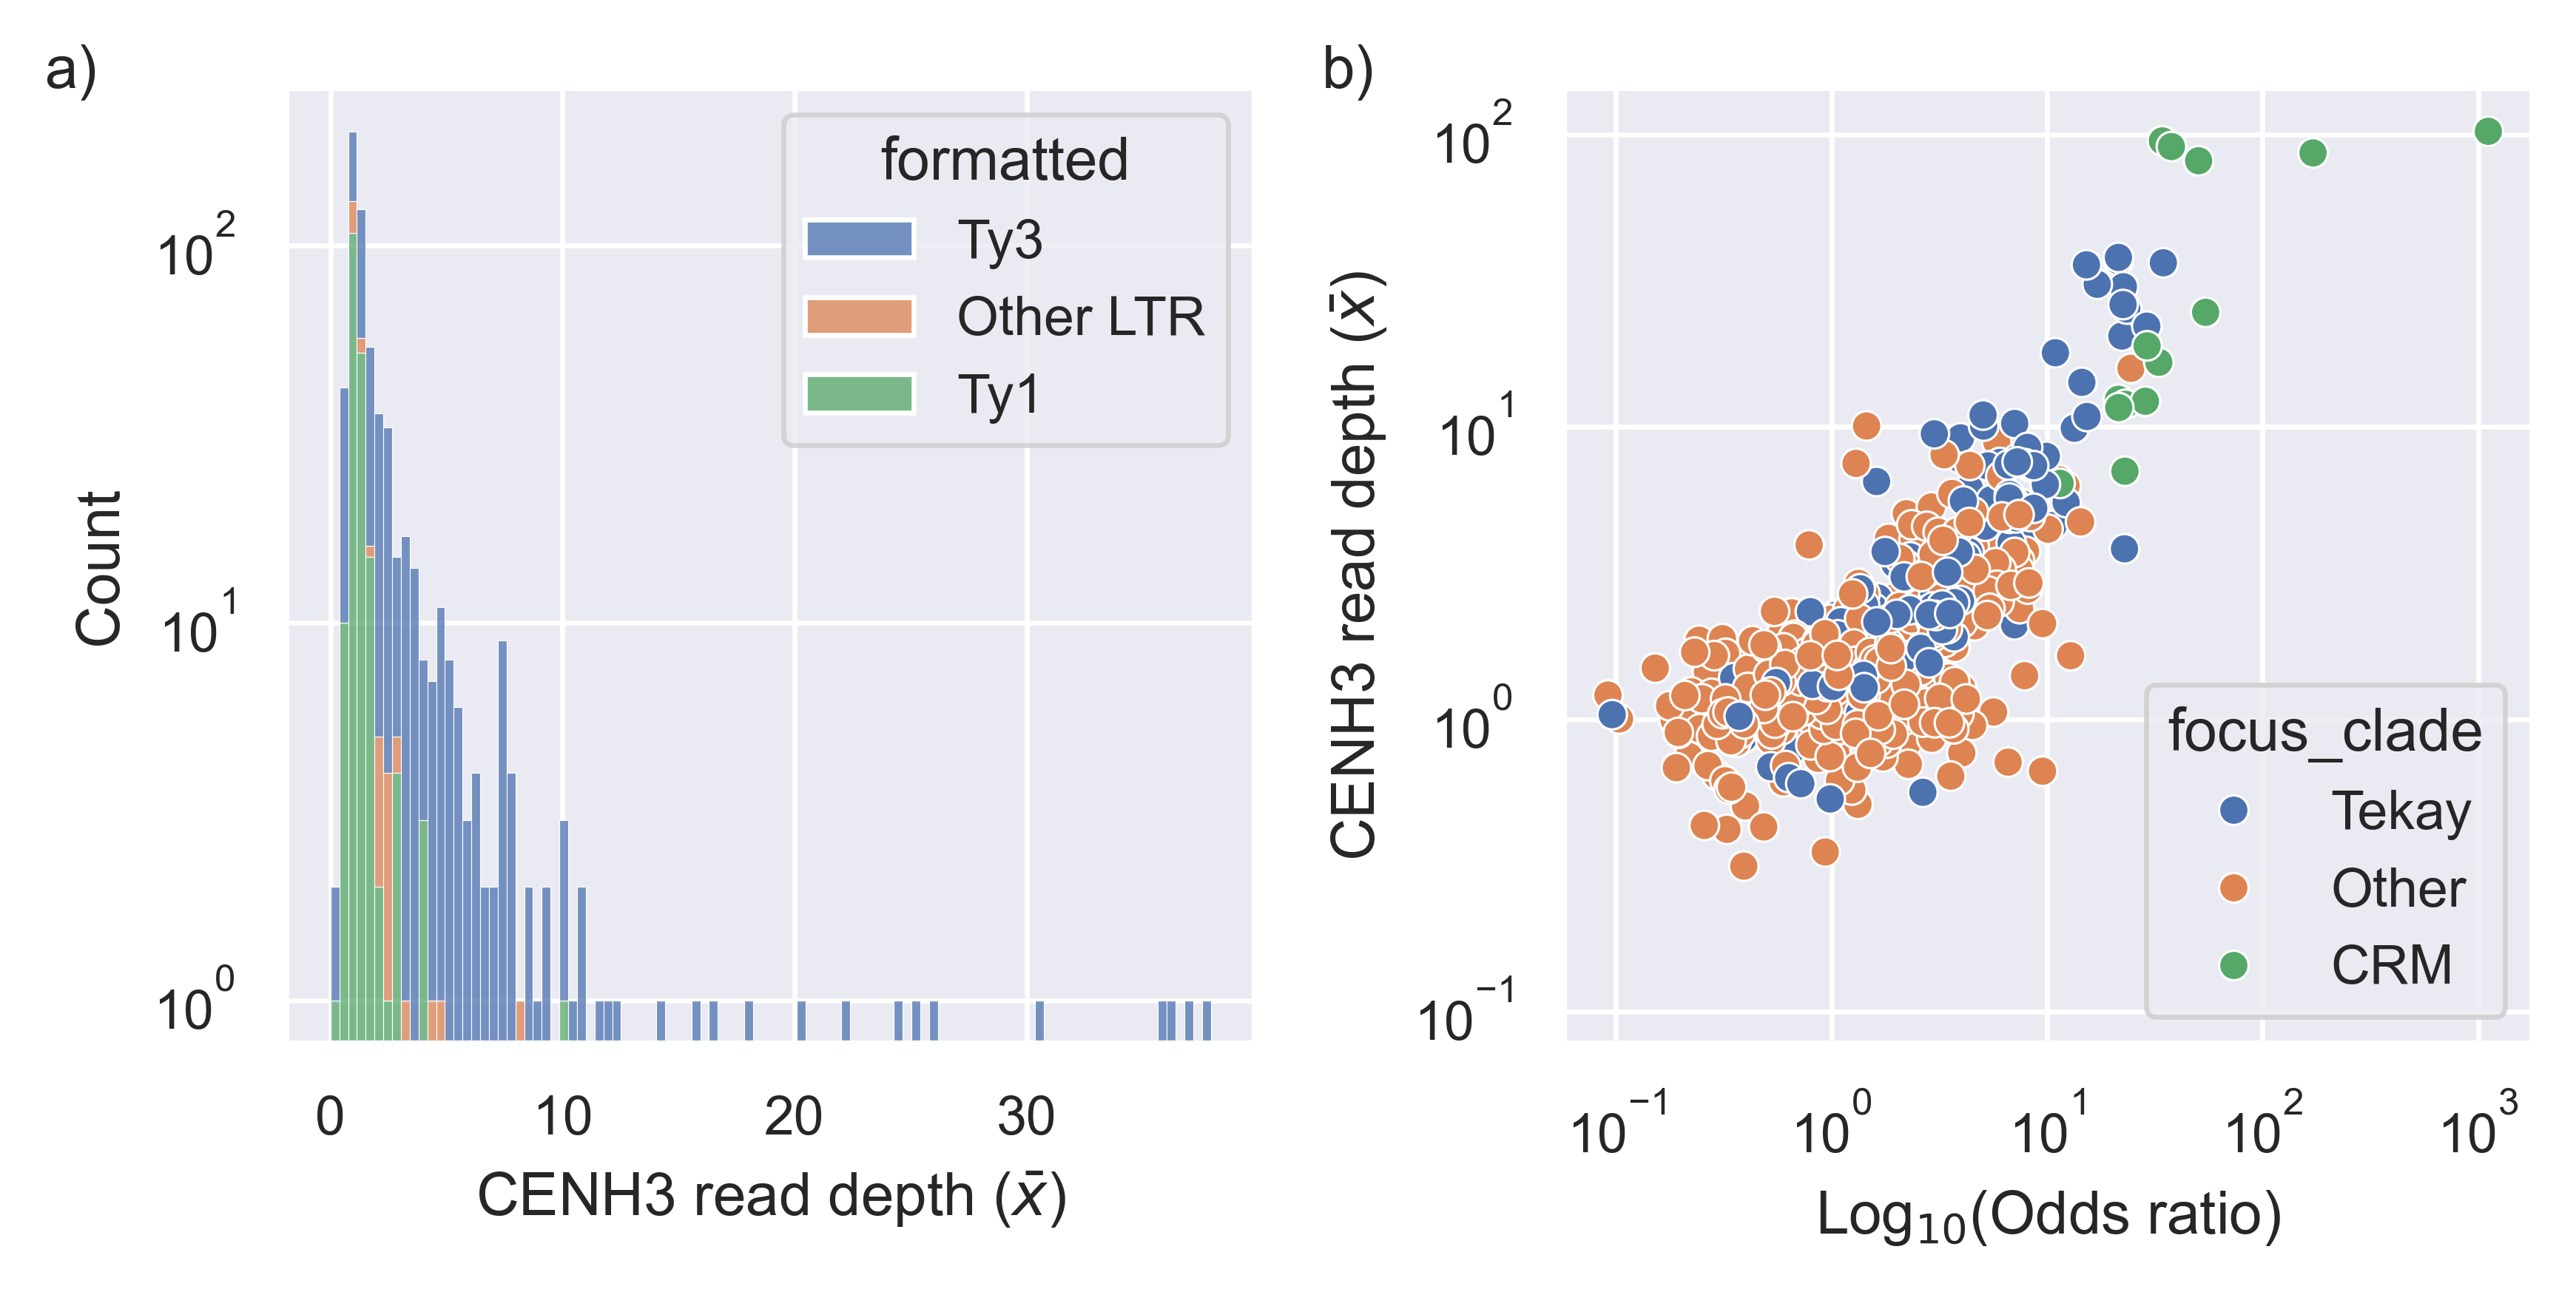

In [24]:
earlgrey_cenh3 = (
    pl.read_csv("../results/earlgrey_cenh3_summary.csv")
    .with_columns(
        (
            pl
            .when(pl.col("column_3").str.contains("Gypsy"))
            .then(pl.lit("Ty3"))
            .when(pl.col("column_3").str.contains("Copia"))
            .then(pl.lit("Ty1"))
            .otherwise(pl.lit("Other LTR"))
            .alias("formatted")
        ),
        pl.col("ID").str.to_lowercase().alias("family"),
    )
)

cenh3_tesorter_odds = (
    earlgrey_cenh3
    .join(tesorter, on="family", how="inner")
    .join(centromere_bias, on="family", how="inner")
    .with_columns(
        (
            pl
            .when(pl.col("Clade") == "CRM")
            .then(pl.lit("CRM"))
            .when(pl.col("Clade") == "Tekay")
            .then(pl.lit("Tekay"))
            .otherwise(pl.lit("Other"))
            .alias("focus_clade")
        )
    )
)

fig = plt.figure(figsize=(5.9, 3), layout="tight", dpi=600)
gs = gridspec.GridSpec(1, 2)

axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]


sns.histplot(
    earlgrey_cenh3.filter(pl.col("column_3").str.contains("LTR")),
    x="sum",
    hue="formatted",
    multiple="stack",
    bins=100,
    ax=axs[0],
)
axs[0].set_yscale("log")
axs[0].set_xlabel(r"CENH3 read depth ($\bar{x}$)")

sns.scatterplot(
    cenh3_tesorter_odds,
    x="odds_ratio",
    y="sum",
    hue="focus_clade",
    ax=axs[1],
)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Log$_{10}$(Odds ratio)")
axs[1].set_ylabel(r"CENH3 read depth ($\bar{x}$)")

for n, ax in enumerate(axs):
    ax.text(
        -0.25,
        1,
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

#plt.savefig("../../pandoc-thesis/figures/earlgrey_cenh3_summary.png")

Lets look at the methylation state of the centromeric LTRs - specifically, the CHG status

In [34]:
# Bedtools map of earlgrey annotations

cg_methylation = (
    pl.read_csv(
        "../results/deepsignal/earlgrey.CG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        pl.lit("CG").alias("type"),
    )
)

chg_methylation = (
    pl.read_csv(
        "../results/deepsignal/earlgrey.CHG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        pl.lit("CHG").alias("type"),
    )
)
# need to infer schema cus too long or something idk
chh_methylation = (
    pl.read_csv(
        "../results/deepsignal/earlgrey.CHH.gff",
        has_header=False,
        separator="\t",
        infer_schema_length=int(1e10)
    )
    .with_columns(
        (pl.col("column_9").str.extract(r"ID=(.*?);")).str.to_lowercase().alias("family"),
        pl.lit("CHH").alias("type"),
    )
)

methylation = (
    pl.concat([cg_methylation, chg_methylation, chh_methylation])
    .select(
        chrom="column_1",
        earlgrey_classification="column_3",
        family="family",
        start="column_4",
        end="column_5",
        type="type",
        proportion="column_10"
    )
    .filter(pl.col("proportion") != ".")
    .with_columns(
        pl.col("proportion").cast(pl.Float32)
    )
)

Lets plot CHG vs CG for the hell of it lol

In [40]:
(
    methylation
    .group_by("family", "earlgrey_classification", "type")
    .agg(pl.mean("proportion").alias("mean_proportion"))
    .pivot(index=["family", "earlgrey_classification"], columns="type", values="mean_proportion")
)

shape: (7_932, 5)
┌───────────────────┬─────────────────────────┬──────────┬──────────┬──────────┐
│ family            ┆ earlgrey_classification ┆ CHG      ┆ CHH      ┆ CG       │
│ ---               ┆ ---                     ┆ ---      ┆ ---      ┆ ---      │
│ str               ┆ str                     ┆ f32      ┆ f32      ┆ f32      │
╞═══════════════════╪═════════════════════════╪══════════╪══════════╪══════════╡
│ (tccggc)n         ┆ Simple_repeat           ┆ 0.771981 ┆ 0.158574 ┆ 0.941002 │
│ (acttatt)n        ┆ Simple_repeat           ┆ 0.0      ┆ 0.035056 ┆ null     │
│ rnd-1_family-423  ┆ Unknown                 ┆ 0.660974 ┆ 0.11481  ┆ 0.868388 │
│ rnd-3_family-1009 ┆ Unknown                 ┆ 0.349646 ┆ 0.044368 ┆ 0.917893 │
│ rnd-5_family-125  ┆ Unknown                 ┆ 0.567988 ┆ 0.284015 ┆ 0.662244 │
│ …                 ┆ …                       ┆ …        ┆ …        ┆ …        │
│ (ttgtaaa)n        ┆ Simple_repeat           ┆ null     ┆ 0.0      ┆ null     │
│ (ttgtgac)n        ┆ Simple_repeat           ┆ null     ┆ 0.0      ┆ null     │
│ (ttgtcaa)n        ┆ Simple_repeat           ┆ null     ┆ 0.004545 ┆ null     │
│ (aattagg)n        ┆ Simple_repeat           ┆ null     ┆ 0.0084   ┆ null     │
│ (tttgaca)n        ┆ Simple_repeat           ┆ null     ┆ 0.0      ┆ null     │
└───────────────────┴─────────────────────────┴──────────┴──────────┴──────────┘

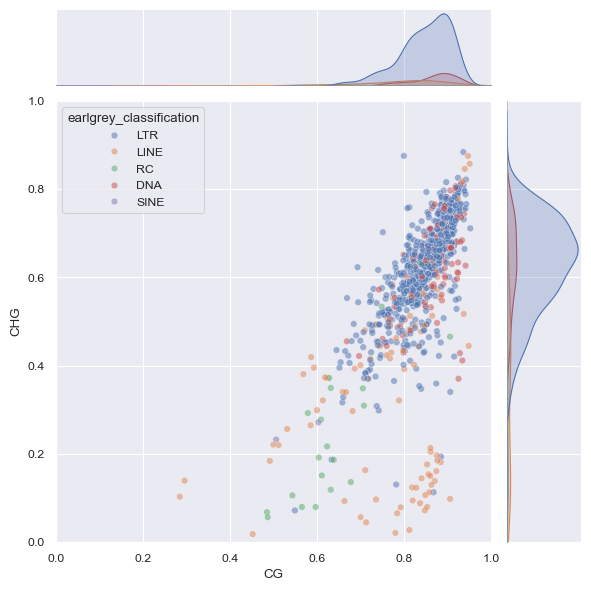

In [60]:
summarised_earlgrey_methylation = (
    (
        methylation
        .with_columns(
            pl.col("earlgrey_classification").str.replace("/.*", "").alias("earlgrey_classification")
        )
        .filter(~pl.col("earlgrey_classification").str.contains("Unknown|Simple_repeat|Satellite|Low_complexity"))
        .group_by("family", "earlgrey_classification", "type")
        .agg(pl.mean("proportion").alias("mean_proportion"))
        .pivot(index=["family", "earlgrey_classification"], columns="type", values="mean_proportion")
    )
)

sns.jointplot(
    summarised_earlgrey_methylation,
    x="CG",
    y="CHG",
    hue="earlgrey_classification",
    alpha=0.5,
    xlim=(0, 1),
    ylim=(0, 1),
)
plt.savefig("../../pandoc-thesis/figures/earlgrey_methylation_scatterplot.png")

earlgre

In [26]:
methylation = (
    methylation
    .join(centromeres, on="chrom", how="left")
    .with_columns(
        (
            (pl.col("start") > pl.col("start_right")) &
            (pl.col("end") < pl.col("end_right"))
        ).alias("inside_centromere")
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_90600/3983547628.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  methylation


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             proportion   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     23.33
Date:                Mon, 17 Jun 2024   Prob (F-statistic):           1.39e-06
Time:                        23:53:19   Log-Likelihood:                 1325.7
No. Observations:                6723   AIC:                            -2647.
Df Residuals:                    6721   BIC:                            -2634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.6129      0.003    225.458      0.000       0.608       0.618
inside_centromere[T.True]    -0.0290      0.006     -4.830      0.000      -0.041      -0.017
==============================================================================
Omnibus:                     1249.962   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2197.248
Skew:                          -1.195   Prob(JB):                         0.00
Kurtosis:                       4.461   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

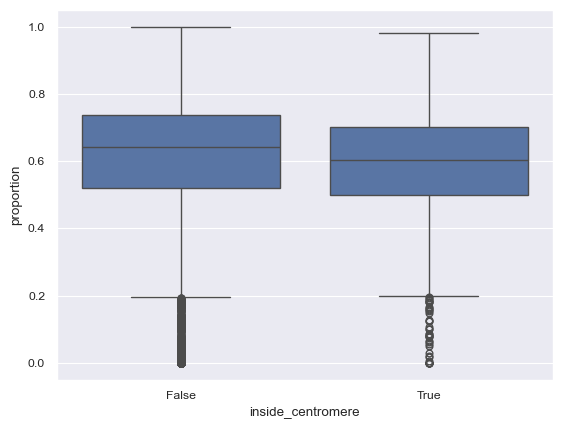

In [31]:
centromere_biased_families = (
    centromere_bias
    .filter(
        (pl.col("p_value") < 0.05) & (pl.col("odds_ratio") > 10)
    )
    .select("family")
)

sns.boxplot(
    (
        methylation
        .filter(pl.col("family").is_in(centromere_biased_families))
        .filter(pl.col("type") == "CHG")
        .filter(pl.col("proportion") != ".")
        .with_columns(
            pl.col("proportion").cast(pl.Float32)
        )
    ),
    x="inside_centromere",
    y="proportion",
)

smf.ols(
    "proportion ~ inside_centromere",
    (
        methylation
        .filter(pl.col("family").is_in(centromere_biased_families))
        .filter(pl.col("type") == "CHG")
        .filter(pl.col("proportion") != ".")
        .with_columns(
            pl.col("proportion").cast(pl.Float32)
        )
    ).to_pandas(),
).fit().summary()

# NLR analysis

Begin by characterising the main patterns of NLRs found here

In [114]:
resistify_result = (
    pl.read_csv(
        "../results/resistify/final/results.tsv",
        separator="\t",
        has_header=True,
    )
    .with_columns(
        (pl.col("Sequence").str.replace(r".[t]?\d$", "").alias("gene")),
        (pl.col("Sequence").str.contains("solanum").alias("helixer")),
    )
    # Select largest transcript for each gene
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
)

canonical_nlrs = (
    resistify_result
    .filter(pl.col("Classification") != "None")
    .select(pl.col("gene"))
    .unique()
)

lcpm = (
    pl.read_csv(
        "../results/tpm.tsv",
        separator="\t",
    )
    .with_columns((pl.col("tpm") + 1).log().alias("lcpm"))
    .select(pl.col("gene"), pl.col("condition"), pl.col("lcpm"))
)

homologs = (
    pl.read_csv(
        "../results/refplantnlr_diamond.tsv",
        separator="\t",
        has_header=False,
    )
    .select(
        sequence=pl.col("column_1"),
        homolog=pl.col("column_2"),
        identity=pl.col("column_3"),
    )
    .with_columns(
        pl.col("sequence").str.replace(r".t\d$", "").alias("gene")
    )
    .filter(pl.col("identity") > 85)
)

How many NLRs are in the genome?

In [117]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .count()
)

shape: (1, 11)
┌──────┬──────────┬────────┬────────┬───┬──────┬───────┬──────┬─────────┐
│ gene ┆ Sequence ┆ Length ┆ Motifs ┆ … ┆ MADA ┆ MADAL ┆ CJID ┆ helixer │
│ ---  ┆ ---      ┆ ---    ┆ ---    ┆   ┆ ---  ┆ ---   ┆ ---  ┆ ---     │
│ u32  ┆ u32      ┆ u32    ┆ u32    ┆   ┆ u32  ┆ u32   ┆ u32  ┆ u32     │
╞══════╪══════════╪════════╪════════╪═══╪══════╪═══════╪══════╪═════════╡
│ 497  ┆ 497      ┆ 497    ┆ 496    ┆ … ┆ 497  ┆ 497   ┆ 497  ┆ 497     │
└──────┴──────────┴────────┴────────┴───┴──────┴───────┴──────┴─────────┘

How many by classification?

In [118]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .group_by("Classification")
    .count()
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/2563212932.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


shape: (7, 2)
┌────────────────┬───────┐
│ Classification ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ N              ┆ 71    │
│ CN             ┆ 66    │
│ TN             ┆ 9     │
│ CNL            ┆ 243   │
│ TNL            ┆ 45    │
│ NL             ┆ 61    │
│ RNL            ┆ 2     │
└────────────────┴───────┘

What proportion of extra modifications?

In [119]:
# Filter isoforms by selecting longest NLR for each gene
(
    resistify_result
    .group_by("gene")
    .agg(pl.all().sort_by("Length").last())
    .filter(pl.col("Classification") != "None")
    .group_by("Classification")
    .agg(pl.sum("MADA"))
)

shape: (7, 2)
┌────────────────┬──────┐
│ Classification ┆ MADA │
│ ---            ┆ ---  │
│ str            ┆ u32  │
╞════════════════╪══════╡
│ N              ┆ 0    │
│ TNL            ┆ 0    │
│ CNL            ┆ 30   │
│ TN             ┆ 0    │
│ CN             ┆ 12   │
│ RNL            ┆ 0    │
│ NL             ┆ 1    │
└────────────────┴──────┘

## Expression analysis

Couple of things to check here.
* Are there differentially expressed NLRs across the different conditions?
* Are there broad changes in NLR expression between conditions?
* Are helixer predictions significantly differentially expressed?
  
Need to do some stats in between these


/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/2407041504.py:33: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/2407041504.py:43: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result
/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/2407041504.py:54: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result


<Axes: xlabel='helixer', ylabel='lcpm'>

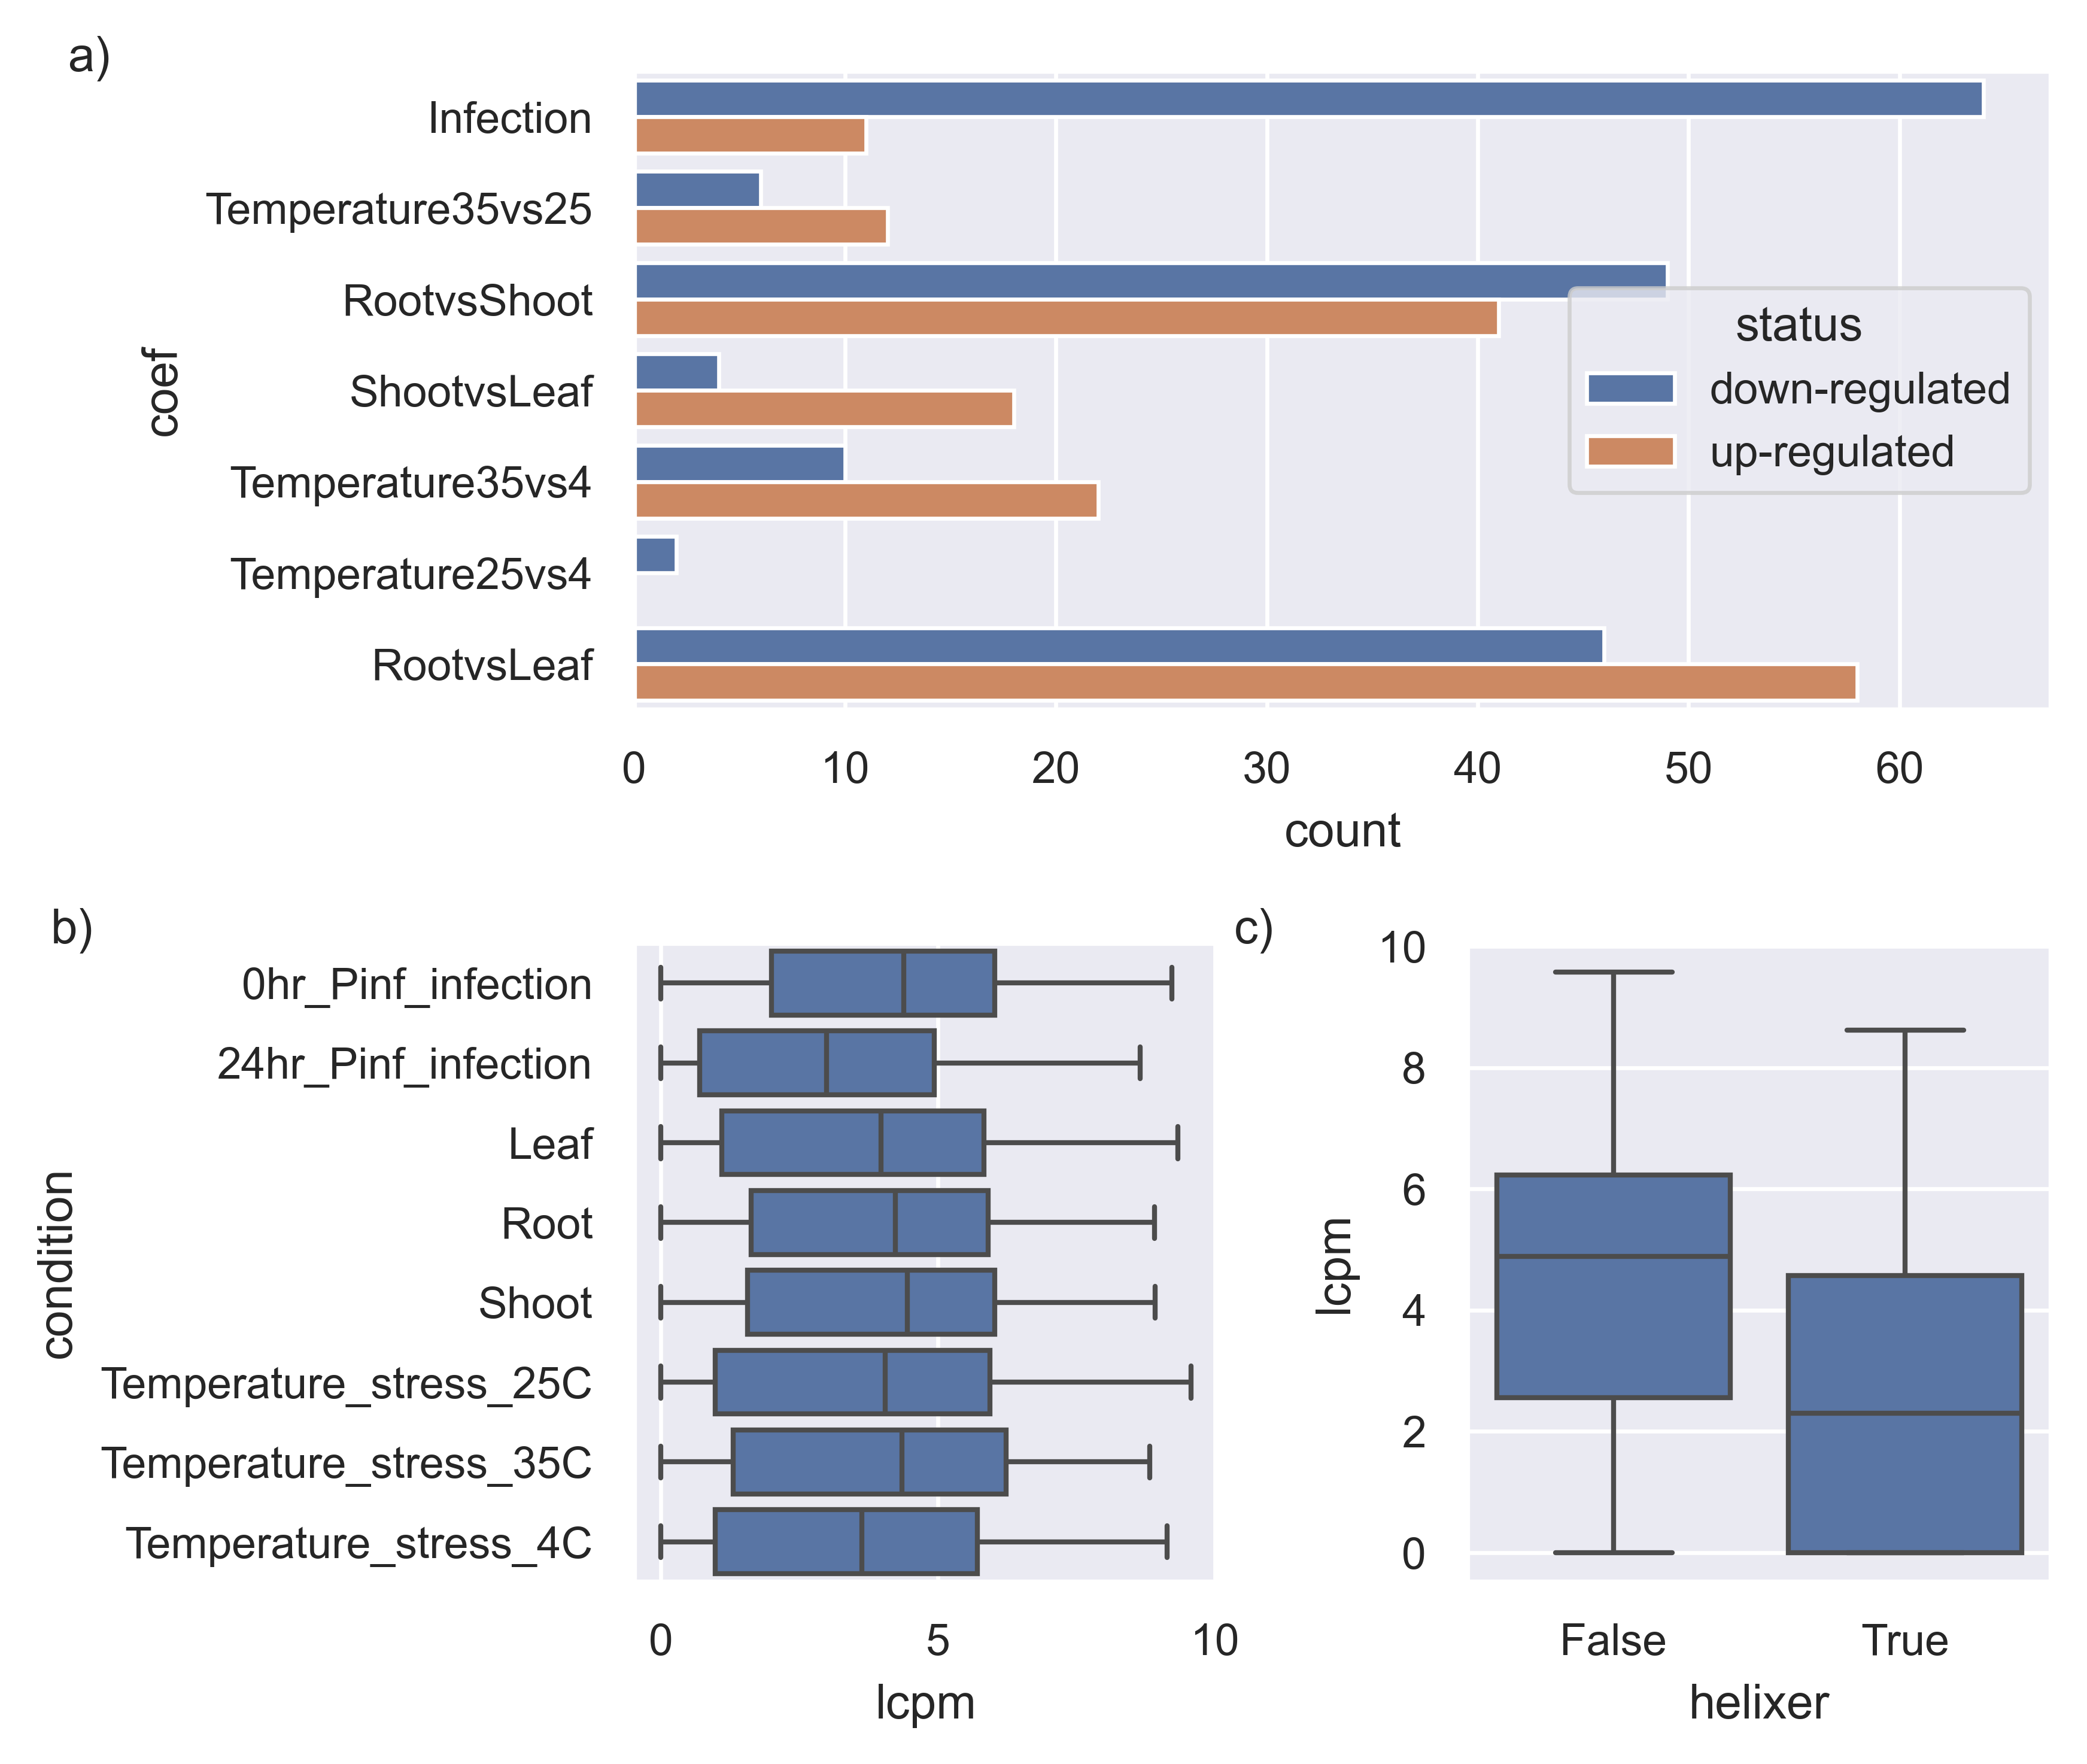

In [120]:
# Differentially expressed NLRs

differential_expression = (
    pl.read_csv(
        "../results/differential_expression.tsv",
        separator="\t",
        has_header=True,
    )
    .filter(pl.col("gene").is_in(canonical_nlrs))
)

fig = plt.figure(figsize=(5.9, 5), layout="tight", dpi=600)
gs = gridspec.GridSpec(2, 2)

axs = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# Add in the subplot labels
label_x_coords = [-0.4, -1, -0.4]
label_y_coords = [1, 1, 1]
for n, ax in enumerate(axs):
    ax.text(
        label_x_coords[n],
        label_y_coords[n],
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

sns.barplot(
    (
        differential_expression
        .filter(pl.col("status") != "not significant")
        .group_by("coef", "status")
        .agg(pl.count().alias("count"))
    ),
    x="count",
    y="coef",
    hue="status",
    ax=axs[0],
)

sns.boxplot(
    (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ),
    y="condition",
    x="lcpm",
    ax=axs[1],
)

sns.boxplot(
    (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ),
    x="helixer",
    y="lcpm",
    ax=axs[2],
)

#plt.savefig("../../pandoc-thesis/figures/nlr_expression.png")

In [121]:
mod = smf.ols(
    formula="lcpm ~ condition + helixer",
    data = (
        resistify_result
        .filter(pl.col("gene").is_in(canonical_nlrs))
        .join(lcpm, on="gene", how="left")
    ).to_pandas(),
)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   lcpm   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     72.89
Date:                Mon, 17 Jun 2024   Prob (F-statistic):          2.61e-112
Time:                        16:52:44   Log-Likelihood:                -8899.7
No. Observations:                3920   AIC:                         1.782e+04
Df Residuals:                    3911   BIC:                         1.787e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/4252222200.py:4: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result


Are the helixer NLRs also more likely teMs?

In [ ]:
(
    resistify_result
    .filter(pl.col("gene").is_in(canonical_nlrs))
    .join(
        (
            subfeature_methylation
            .filter(pl.col("column_3").str.contains("exon"))
            .with_columns(pl.col("gene").str.replace(r"\.\d$", "").alias("gene"))
            .select(["gene", "classification"])
        ),
        on="gene",
    )
    .group_by("helixer")
    .agg(
        (pl.col("classification") == "teM") 
    )
)

## Transposable element overlaps

In [215]:
edta_overlap_nlrs = (
    pl.read_csv(
        "../results/final_annotation/final_annotation.longest.edta_overlap.bed",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        pl.col("column_4").str.replace(r"\..*$", "").alias("gene"),
    )
    .filter(
        (pl.col("column_19") / (pl.col("column_3") - pl.col("column_2"))) > 0.9
    )
    .unique()
    .filter(pl.col("gene").is_in(canonical_nlrs))
    .select("gene", "column_12")
    .join(
        (
            subfeature_methylation
            .with_columns(pl.col("gene").str.replace(r"\.\d$", "").alias("gene"))
        ),
        on="gene",
        how="left"
    )
)

edta_overlap_nlrs

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/3047427094.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  pl.read_csv(


shape: (43, 7)
┌──────────────────┬──────────────────┬──────────┬──────────┬──────────┬──────────┬────────────────┐
│ gene             ┆ column_12        ┆ column_3 ┆ CHG      ┆ CG       ┆ CHH      ┆ classification │
│ ---              ┆ ---              ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---            │
│ str              ┆ str              ┆ str      ┆ f64      ┆ f64      ┆ f64      ┆ str            │
╞══════════════════╪══════════════════╪══════════╪══════════╪══════════╪══════════╪════════════════╡
│ g18080           ┆ repeat_region    ┆ intron   ┆ 0.666121 ┆ 0.932243 ┆ 0.11707  ┆ teM            │
│ g18080           ┆ repeat_region    ┆ exon     ┆ 0.61127  ┆ 0.87115  ┆ 0.120878 ┆ teM            │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.817029 ┆ 0.936423 ┆ 0.132179 ┆ teM            │
│ um_chr04_00243…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.252817 ┆ 0.586817 ┆ 0.018301 ┆ ambiguous      │
│ um_chr04_00243…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.024903 ┆ 0.415304 ┆ 0.004281 ┆ gbM            │
│ um_chr04_00062…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ …                ┆ …                ┆ …        ┆ …        ┆ …        ┆ …        ┆ …              │
│ g30612           ┆ CACTA_TIR_transp ┆ intron   ┆ 0.0      ┆ NaN      ┆ 0.0      ┆ gbM            │
│                  ┆ oson             ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ Mutator_TIR_tran ┆ exon     ┆ 0.018063 ┆ 0.253627 ┆ 0.001266 ┆ gbM            │
│ um_chr06_00076…  ┆ sposon           ┆          ┆          ┆          ┆          ┆                │
│ g11617           ┆ helitron         ┆ exon     ┆ 0.00433  ┆ 0.090218 ┆ 0.001563 ┆ ambiguous      │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.00835  ┆ 0.464787 ┆ 0.001618 ┆ gbM            │
│ um_chr02_00263…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.104936 ┆ 0.73937  ┆ 0.028814 ┆ ambiguous      │
│ um_chr04_00303…  ┆                  ┆          ┆          ┆          ┆          ┆                │
└──────────────────┴──────────────────┴──────────┴──────────┴──────────┴──────────┴────────────────┘

Are they differentially methylated?

In [214]:
(
    edta_overlap_nlrs
    .join(
        (
            subfeature_methylation
            .with_columns(pl.col("gene").str.replace(r"\.\d$", "").alias("gene"))
        ),
        on="gene",
        how="left"
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/3562685083.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  edta_overlap_nlrs


shape: (43, 7)
┌──────────────────┬──────────────────┬──────────┬──────────┬──────────┬──────────┬────────────────┐
│ gene             ┆ column_12        ┆ column_3 ┆ CHG      ┆ CG       ┆ CHH      ┆ classification │
│ ---              ┆ ---              ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---            │
│ str              ┆ str              ┆ str      ┆ f64      ┆ f64      ┆ f64      ┆ str            │
╞══════════════════╪══════════════════╪══════════╪══════════╪══════════╪══════════╪════════════════╡
│ g11616           ┆ helitron         ┆ exon     ┆ 0.005242 ┆ 0.060906 ┆ 0.000834 ┆ ambiguous      │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.585344 ┆ 0.754793 ┆ 0.106618 ┆ teM            │
│ um_chr06_00033…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.252817 ┆ 0.586817 ┆ 0.018301 ┆ ambiguous      │
│ um_chr04_00243…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.017531 ┆ 0.433478 ┆ 0.006091 ┆ gbM            │
│ um_chr04_00024…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.018339 ┆ 0.813814 ┆ 0.004871 ┆ gbM            │
│ um_chr04_00025…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ …                ┆ …                ┆ …        ┆ …        ┆ …        ┆ …        ┆ …              │
│ g11615           ┆ helitron         ┆ exon     ┆ 0.006589 ┆ 0.321554 ┆ 0.0026   ┆ gbM            │
│ solanum_verrucos ┆ helitron         ┆ exon     ┆ 0.139459 ┆ 0.0278   ┆ 0.003675 ┆ ambiguous      │
│ um_chr09_00150…  ┆                  ┆          ┆          ┆          ┆          ┆                │
│ solanum_verrucos ┆ Mutator_TIR_tran ┆ exon     ┆ 0.012447 ┆ 0.846375 ┆ 0.00572  ┆ gbM            │
│ um_chr05_00207…  ┆ sposon           ┆          ┆          ┆          ┆          ┆                │
│ g18080           ┆ Copia_LTR_retrot ┆ intron   ┆ 0.666121 ┆ 0.932243 ┆ 0.11707  ┆ teM            │
│                  ┆ ransposon        ┆          ┆          ┆          ┆          ┆                │
│ g18080           ┆ Copia_LTR_retrot ┆ exon     ┆ 0.61127  ┆ 0.87115  ┆ 0.120878 ┆ teM            │
│                  ┆ ransposon        ┆          ┆          ┆          ┆          ┆                │
└──────────────────┴──────────────────┴──────────┴──────────┴──────────┴──────────┴────────────────┘

## Rpi-ver1 locus

In [148]:
kasp_markers = (
    pl.read_csv(
        "../results/kasp_blast.tsv",
        separator="\t",
        has_header=False,
    )
    .filter(pl.col("column_3") == 100)
    .select(
        marker=pl.col("column_1"),
        chrom=pl.col("column_2"),
        start=pl.col("column_9"),
        end=pl.col("column_10"),
    )
)

# Print the small loci boundaries
(
    kasp_markers
    .filter(pl.col("marker").str.contains("DMG400017237|DMG400017146"))
    .group_by("chrom")
    .agg(pl.min("start"), pl.max("end"))
)

shape: (1, 3)
┌───────┬──────────┬──────────┐
│ chrom ┆ start    ┆ end      │
│ ---   ┆ ---      ┆ ---      │
│ str   ┆ i64      ┆ i64      │
╞═══════╪══════════╪══════════╡
│ chr09 ┆ 54606140 ┆ 55951334 │
└───────┴──────────┴──────────┘

Get a list of all the genes present in this locus

In [165]:
rpiver1_candidates = (
    gff
    .filter(
        (pl.col("seqid") == "chr09") &
        (pl.col("start") > 54606140) &
        (pl.col("end") < 55951334)
    )
    .select("gene")
    .unique()
)

Import the GO term annotations

In [166]:
go_annotation = (
    pl.read_csv(
        "../results/eggnog/eggnog.emapper.annotations",
        separator="\t",
        comment_prefix="#",
        has_header=False,
    )
    .with_columns(
        pl.col("column_1").str.extract(r"^(.*?)\..*").alias("gene"),
    )
)
go_annotation

shape: (44_994, 22)
┌───────────┬────────────┬────────────┬──────────┬───┬───────────┬───────────┬────────────┬────────┐
│ column_1  ┆ column_2   ┆ column_3   ┆ column_4 ┆ … ┆ column_19 ┆ column_20 ┆ column_21  ┆ gene   │
│ ---       ┆ ---        ┆ ---        ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---        ┆ ---    │
│ str       ┆ str        ┆ f64        ┆ f64      ┆   ┆ str       ┆ str       ┆ str        ┆ str    │
╞═══════════╪════════════╪════════════╪══════════╪═══╪═══════════╪═══════════╪════════════╪════════╡
│ g1.t1     ┆ 4081.Solyc ┆ 0.0        ┆ 2498.0   ┆ … ┆ -         ┆ -         ┆ DCB,DUF198 ┆ g1     │
│           ┆ 01g112350. ┆            ┆          ┆   ┆           ┆           ┆ 1,Mon2_C,S ┆        │
│           ┆ 2.1        ┆            ┆          ┆   ┆           ┆           ┆ ec7,Sec7_N ┆        │
│ g3.t1     ┆ 4098.XP_00 ┆ 0.0        ┆ 911.0    ┆ … ┆ -         ┆ -         ┆ ARID,HSP20 ┆ g3     │
│           ┆ 9612453.1  ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g3.t2     ┆ 4098.XP_00 ┆ 0.0        ┆ 907.0    ┆ … ┆ -         ┆ -         ┆ ARID,HSP20 ┆ g3     │
│           ┆ 9612453.1  ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g4.t1     ┆ 4081.Solyc ┆ 0.0        ┆ 1507.0   ┆ … ┆ -         ┆ -         ┆ FAR1,MULE, ┆ g4     │
│           ┆ 01g112320. ┆            ┆          ┆   ┆           ┆           ┆ SWIM       ┆        │
│           ┆ 2.1        ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g5.t1     ┆ 4096.XP_00 ┆ 2.9400e-68 ┆ 229.0    ┆ … ┆ -         ┆ -         ┆ RVT_1      ┆ g5     │
│           ┆ 9765421.1  ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ …         ┆ …          ┆ …          ┆ …        ┆ … ┆ …         ┆ …         ┆ …          ┆ …      │
│ g36369.t2 ┆ 4113.PGSC0 ┆ 6.4500e-12 ┆ 354.0    ┆ … ┆ -         ┆ -         ┆ -          ┆ g36369 │
│           ┆ 003DMT4000 ┆ 2          ┆          ┆   ┆           ┆           ┆            ┆        │
│           ┆ 92742      ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g36370.t1 ┆ 3847.GLYMA ┆ 2.9600e-38 ┆ 147.0    ┆ … ┆ -         ┆ -         ┆ -          ┆ g36370 │
│           ┆ 13G11980.1 ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g36372.t1 ┆ 3847.GLYMA ┆ 9.5900e-82 ┆ 270.0    ┆ … ┆ -         ┆ -         ┆ -          ┆ g36372 │
│           ┆ 13G11980.1 ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g36373.t1 ┆ 4113.PGSC0 ┆ 7.6100e-70 ┆ 215.0    ┆ … ┆ -         ┆ -         ┆ -          ┆ g36373 │
│           ┆ 003DMT4000 ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│           ┆ 89859      ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│ g36374.t1 ┆ 225117.XP_ ┆ 1.0500e-36 ┆ 137.0    ┆ … ┆ -         ┆ -         ┆ -          ┆ g36374 │
│           ┆ 009366572. ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
│           ┆ 1          ┆            ┆          ┆   ┆           ┆           ┆            ┆        │
└───────────┴────────────┴────────────┴──────────┴───┴───────────┴───────────┴────────────┴────────┘

In [181]:
rpiver1_candidates_joined = (
    rpiver1_candidates
    .join(
        (
            go_annotation
            .group_by("gene")
            .agg(pl.all().sort_by("column_3").last())
            .select(gene=pl.col("gene"), description=pl.col("column_8"))
        ),
        on="gene",
        how="left"
    )
    .join(
        (
            lcpm
            .group_by("gene")
            .agg(pl.mean("lcpm"))
        ),
        on="gene",
        how="left"
    )
    .join(
        (
            resistify_result
            .select(gene="gene", NLR_motifs="Motifs")
        ),
        on="gene",
        how="left"
    )
    .filter(pl.col("lcpm") > 1)
)

with pl.Config() as cfg:
    cfg.set_tbl_formatting("ASCII_HORIZONTAL_ONLY")
    cfg.set_tbl_hide_column_data_types(True)
    cfg.set_fmt_str_lengths(100)
    cfg.set_tbl_rows(-1)
    print(rpiver1_candidates_joined)

shape: (73, 4)
----------------------------------------------------------------------------------------------------
 gene     description                                           lcpm       NLR_motifs               
 g27423   -                                                     7.792773   null                     
----------------------------------------------------------------------------------------------------
 g27474   CCT motif                                             3.429826   null                     
----------------------------------------------------------------------------------------------------
 g27400   Germin-like protein subfamily 1 member 17             1.346383   null                     
----------------------------------------------------------------------------------------------------
 g27475   Prp19/Pso4-like                                       7.985442   null                     
----------------------------------------------------------------------------

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/1165173473.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  rpiver1_candidates


Check for NLRs in wider locus

In [218]:
(
    kasp_markers
    .filter(pl.col("marker").str.contains("DMG400011401|NLR0226"))
    .group_by("chrom")
    .agg(pl.min("start"), pl.max("end"))
)

rpiver1__wide_candidates = (
    gff
    .filter(
        (pl.col("seqid") == "chr09") &
        (pl.col("start") > 51196801) &
        (pl.col("end") < 58124447)
    )
    .select("gene")
    .unique()
)

rpiver1__wide_candidates = (
    resistify_result
    .filter(pl.col("gene").is_in(canonical_nlrs))
    .filter(pl.col("gene").is_in(rpiver1__wide_candidates))
    .join(
        (
            subfeature_methylation
            .filter(pl.col("column_3").str.contains("exon"))
            .with_columns(pl.col("gene").str.replace(r"\.\d$", "").alias("gene"))
        ),
        on="gene",
        how="left"
    )
    .join(
        (
            lcpm
            .group_by("gene")
            .agg(pl.mean("lcpm"))
        ),
        on="gene",
        how="left"
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_7802/3324249952.py:20: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  resistify_result
